In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import copy as cp
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score, cross_val_predict 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score

from typing import Tuple

In [2]:
pd.set_option("display.max_columns", 200)
pd.set_option("display.max_row", 160)
pd.set_option('max_colwidth', 200)

In [4]:
a = pd.read_csv('../Data/accepted.csv')
a.head(3)

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,leadman,10+ years,MORTGAGE,55000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.action?loan_id=68407277,NaN,debt_consolidation,Debt consolidation,190xx,PA,5.91,0.0,Aug-2003,675.0,679.0,1.0,30.0,NaN,7.0,0.0,2765.0,29.7,13.0,w,0.0,0.0,4421.723917,4421.72,3600.0,821.72,0.0,0.0,0.0,Jan-2019,122.67,NaN,Mar-2019,564.0,560.0,0.0,30.0,1.0,Individual,NaN,NaN,NaN,0.0,722.0,144904.0,2.0,2.0,0.0,1.0,21.0,4981.0,36.0,3.0,3.0,722.0,34.0,9300.0,3.0,1.0,4.0,4.0,20701.0,1506.0,37.2,0.0,0.0,148.0,128.0,3.0,3.0,1.0,4.0,69.0,4.0,69.0,2.0,2.0,4.0,2.0,5.0,3.0,4.0,9.0,4.0,7.0,0.0,0.0,0.0,3.0,76.9,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,Engineer,10+ years,MORTGAGE,65000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.action?loan_id=68355089,NaN,small_business,Business,577xx,SD,16.06,1.0,Dec-1999,715.0,719.0,4.0,6.0,NaN,22.0,0.0,21470.0,19.2,38.0,w,0.0,0.0,25679.660000,25679.66,24700.0,979.66,0.0,0.0,0.0,Jun-2016,926.35,NaN,Mar-2019,699.0,695.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,204396.0,1.0,1.0,0.0,1.0,19.0,18005.0,73.0,2.0,3.0,6472.0,29.0,111800.0,0.0,0.0,6.0,4.0,9733.0,57830.0,27.1,0.0,0.0,113.0,192.0,2.0,2.0,4.0,2.0,NaN,0.0,6.0,0.0,5.0,5.0,13.0,17.0,6.0,20.0,27.0,5.0,22.0,0.0,0.0,0.0,2.0,97.4,7.7,0.0,0.0,314017.0,39475.0,79300.0,246

In [5]:
a.shape

(2260701, 151)

In [6]:
#Remove all obserations with No Funded Amount First, How many:
print(len(a[a.funded_amnt.isnull()]))

33


In [7]:
drop = a[a.funded_amnt.isnull()].index
a.drop(drop, axis=0, inplace=True)
a.shape

(2260668, 151)

In [8]:
#No more NaN funded amounts: 
a[a.funded_amnt.isna()].shape

(0, 151)

In [9]:
#Create new column and map Charged Off = 0, Fully Paid = 1
a['loan_status_bin'] = a['loan_status'].map({'Charged Off':0, 'Fully Paid':1})

In [10]:
#Drop all loans which do not classify as "Fully Paid" or "Charged Off":
drop2 = a[a.loan_status_bin.isnull()].index
a.drop(drop2, axis=0, inplace=True)
a.shape

(1345310, 152)

In [11]:
#Taking all loans with interest rate greater than or equal to 20%: 
a = a[a.int_rate >= 20].reset_index(drop=True)
a.shape

(110144, 152)

In [12]:
#Remove all observations with "Joint Applications". 
a = a[a.application_type == 'Individual'].reset_index(drop=True)
a.shape

(106009, 152)

In [13]:
#Overall Return On Investment If Invested In All Loans > 20% interes rate ==> -3.6%
a['total_pymnt_inv'].sum() / a['funded_amnt_inv'].sum()

0.9643770437148663

In [14]:
#Bin Loans By Loan Amount (10K increment) & View Repayment Rates:
a.rename(columns={'loan_status':'Loan Outcome'}, inplace=True)
a['Loan Outcome'].replace({'Charged Off':'Defaulted'}, inplace=True)
#a.head(2)

In [15]:
#Bin the Loans By Loan Amount:
bins=[0,10000,20000,30000,40000]
labels=['0K~10K', '10K~20K', '20K~30K', '30K~40K']
a['Loan Bin'] = pd.cut(a['loan_amnt'], bins=bins,
                      labels=labels, include_lowest=True)

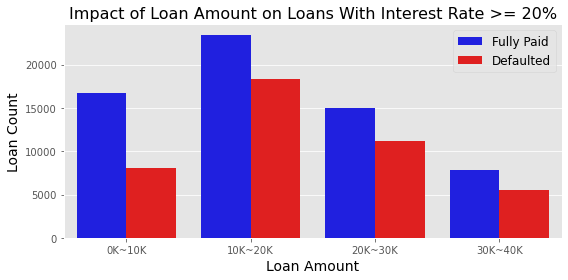

In [16]:
plt.figure(figsize=(8,4))
plt.style.use('default')
plt.style.use('ggplot')

#y=np.arange(len())

sns.countplot(data=a, x='Loan Bin', 
              hue='Loan Outcome', 
              hue_order=['Fully Paid', 'Defaulted'], order = ['0K~10K', '10K~20K', '20K~30K', '30K~40K'],
              palette={'Defaulted':'red','Fully Paid':'blue'});#.set_xticklabels(['None', '0 to 1', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10+ Years'], rotation=45)

plt.title('Impact of Loan Amount on Loans With Interest Rate >= 20%', fontsize=16, color='black')
plt.xlabel('Loan Amount', fontsize=14, color='black')
plt.ylabel('Loan Count', fontsize=14, color='black')
#plt.xticks(['Less than 10K', '10K~20K', '20K~30K', '30K~40K'])
#plt.yticks([])
plt.legend(fontsize=12)
#plt.ticklabel_format(style='plain')

#plt.ylabel('Application Status', fontsize=14, color='blue')

#plt.text(10, 0.98, '9.4%', fontsize=10)

#plt.annotate('90%', xy=(10, 0.25), xytext=(10, 0.25),
            # arrowprops=dict(facecolor='black', shrink=0.05), fontsize=14)

#plt.annotate('0.7%', xy=(80000, 0.15), xytext=(90000, 0.25),
#             arrowprops=dict(facecolor='black', shrink=0.05), fontsize=14)

#plt.margins(x=0.15)
#plt.yticks(fontsize=12)

plt.tight_layout()
plt.show();


In [17]:
a[['Loan Bin','Loan Outcome']].groupby('Loan Bin').describe()

Loan Outcome                          
                count unique         top   freq
Loan Bin                                       
0K~10K          24696      2  Fully Paid  16683
10K~20K         41757      2  Fully Paid  23469
20K~30K         26218      2  Fully Paid  15015
30K~40K         13338      2  Fully Paid   7790

In [18]:
(24696-16683) / 24696

0.32446550048590866

In [19]:
((41757+26218+13338)-(23469+15015+7790)) / (41757+26218+13338)

0.43091510582563675

In [20]:
#Bin the Loans By Loan Amount:
bins=[0,9000,40000]
labels=['0K~9K', '9K~40K']
a['Loan Bin Special'] = pd.cut(a['loan_amnt'], bins=bins,
                      labels=labels, right=False)

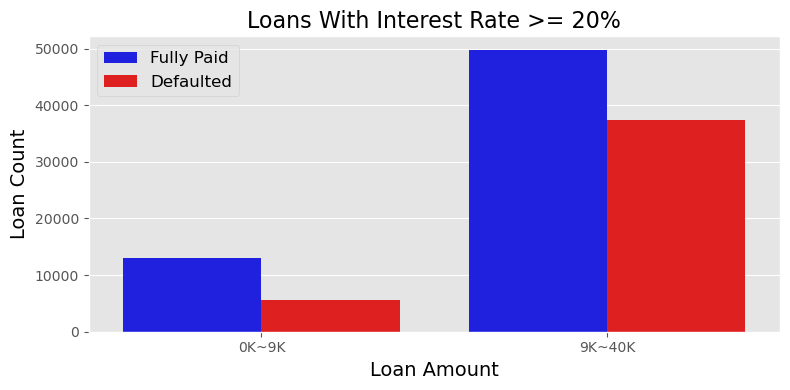

In [21]:
plt.figure(figsize=(8,4))
plt.style.use('default')
plt.style.use('ggplot')

#y=np.arange(len())

sns.countplot(data=a, x='Loan Bin Special', 
              hue='Loan Outcome', 
              hue_order=['Fully Paid', 'Defaulted'], order = ['0K~9K', '9K~40K'],
              palette={'Defaulted':'red','Fully Paid':'blue'});#.set_xticklabels(['None', '0 to 1', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10+ Years'], rotation=45)

plt.title('Loans With Interest Rate >= 20%', fontsize=16, color='black')
plt.xlabel('Loan Amount', fontsize=14, color='black')
plt.ylabel('Loan Count', fontsize=14, color='black')
#plt.xticks(['Less than 10K', '10K~20K', '20K~30K', '30K~40K'])
#plt.yticks([])
plt.legend(fontsize=12, loc='upper left')
#plt.ticklabel_format(style='plain')

#plt.ylabel('Application Status', fontsize=14, color='blue')

#plt.text(10, 0.98, '9.4%', fontsize=10)

#plt.annotate('90%', xy=(10, 0.25), xytext=(10, 0.25),
            # arrowprops=dict(facecolor='black', shrink=0.05), fontsize=14)

#plt.annotate('0.7%', xy=(80000, 0.15), xytext=(90000, 0.25),
#             arrowprops=dict(facecolor='black', shrink=0.05), fontsize=14)

#plt.margins(x=0.15)
#plt.yticks(fontsize=12)

plt.tight_layout()
plt.show();

In [22]:
a[['Loan Bin Special','Loan Outcome']].groupby('Loan Bin Special').describe()

Loan Outcome                          
                        count unique         top   freq
Loan Bin Special                                       
0K~9K                   18706      2  Fully Paid  13076
9K~40K                  86983      2  Fully Paid  49675

In [23]:
(18706-13076)/18706

0.3009729498556613

In [24]:
(86983-49675)/86983

0.4289113964797719

In [25]:
TenK = a[a['Loan Bin']=='0K~10K']
TenK

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,Loan Outcome,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term,loan_status_bin,Loan Bin,Loan Bin Special
10,68537123,NaN,8775.0,8775.0,8775.0,36 months,22.45,337.17,F,F1,Service Rep,10+ years,RENT,75000.0,Source Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.action?loan_id=68537123,NaN,credit_card,Credit card refinancing,308xx,GA,20.37,0.0,Sep-2006,660.0,664.0,4.0,60.0,65.0,14.0,1.0,7613.0,33.4,44.0,w,0.0,0.0,9369.550000,9369.55,8775.00,594.55,0.0,0.0,0.0,Apr-2016,8717.10,NaN,Mar-2019,654.0,650.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,328.0,65963.0,3.0,2.0,1.0,5.0,1.0,58350.0,69.0,5.0,13.0,3737.0,51.0,22800.0,16.0,2.0,16.0,18.0,4712.0,957.0,87.7,0.0,0.0,111.0,102.0,0.0,0.0,0.0,2.0,60.0,0.0,60.0,0.0,5.0,6.0,5.0,13.0,19.0,12.0,25.0,6.0,14.0,0.0,0.0,0.0,6.0,95.5,60.0,0.0,1.0,87952.0,65963.0,7800.0,65152.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0K~10K,0K~9K
15,68516426,NaN,9975.0,9975.0,9975.0,36 months,23.13,386.81,F,F2,Staff Bookkeeper,9 years,OWN,31200.0,Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.action?loan_id=68516426,NaN,other,Other,920xx,CA,21.14,0.0,May-1981,685.0,689.0,0.0,NaN,NaN,10.0,0.0,9075.0,35.6,12.0,w,0.0,0.0,13955.745954,13955.75,9975.00,3980.75,0.0,0.0,0.0,Jan-2019,386.61,NaN,Jan-2019,749.0,745.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,399.0,25019.0,1.0,1.0,1.0,1.0,1.0,15944.0,100.0,0.0,0.0,4184.0,60.0,25500.0,0.0,1.0,0.0,1.0,2502.0,7347.0,54.1,0.0,0.0,1.0,415.0,35.0,1.0,0.0,35.0,NaN,NaN,NaN,0.0,4.0,5.0,5.0,5.0,1.0,9.0,11.0,5.0,10.0,0.0,0.0

In [26]:
#Bin the Loans By Loan Amount:
bins=[0,1000,2000,3000,4000,5000,6000,7000,8000,9000,10000]
labels=['0K~1K', '1K~2K', '2K~3K', '3K~4K', '4K~5K', '5K~6K',
        '6K~7K', '7K~8K', '8K~9K', '9K~10K']
TenK['Loan Bin 10K'] = pd.cut(TenK['loan_amnt'], bins=bins,
                      labels=labels, include_lowest=True)

/var/folders/kl/4xt5tydd0xb8yvwkgnx2mnc00000gn/T/ipykernel_11679/1324326024.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  TenK['Loan Bin 10K'] = pd.cut(TenK['loan_amnt'], bins=bins,


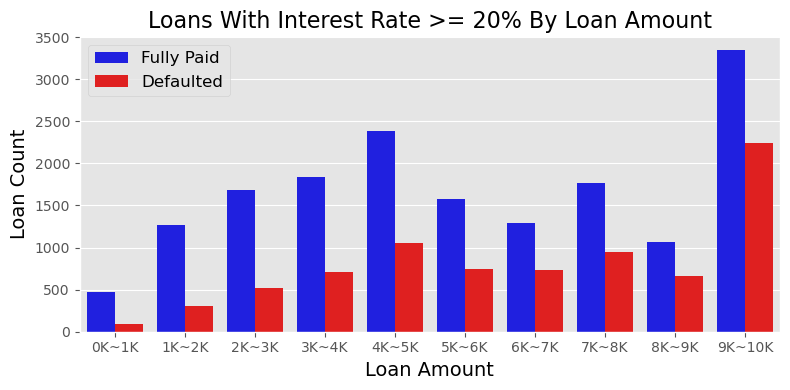

In [27]:
plt.figure(figsize=(8,4))
plt.style.use('default')
plt.style.use('ggplot')

#y=np.arange(len())

sns.countplot(data=TenK, x='Loan Bin 10K', 
              hue='Loan Outcome', 
              hue_order=['Fully Paid', 'Defaulted'], 
              order = ['0K~1K', '1K~2K', '2K~3K', '3K~4K', '4K~5K', '5K~6K', '6K~7K', '7K~8K', '8K~9K', '9K~10K'],
              palette={'Defaulted':'red','Fully Paid':'blue'});#.set_xticklabels(['None', '0 to 1', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10+ Years'], rotation=45)

plt.title('Loans With Interest Rate >= 20% By Loan Amount', fontsize=16, color='black')
plt.xlabel('Loan Amount', fontsize=14, color='black')
plt.ylabel('Loan Count', fontsize=14, color='black')
#plt.xticks(['Less than 10K', '10K~20K', '20K~30K', '30K~40K'])
#plt.yticks([])
plt.legend(fontsize=12)
#plt.ticklabel_format(style='plain')

#plt.ylabel('Application Status', fontsize=14, color='blue')

#plt.text(10, 0.98, '9.4%', fontsize=10)

#plt.annotate('90%', xy=(10, 0.25), xytext=(10, 0.25),
            # arrowprops=dict(facecolor='black', shrink=0.05), fontsize=14)

#plt.annotate('0.7%', xy=(80000, 0.15), xytext=(90000, 0.25),
#             arrowprops=dict(facecolor='black', shrink=0.05), fontsize=14)

#plt.margins(x=0.15)
#plt.yticks(fontsize=12)

plt.tight_layout()
plt.show();


In [28]:
#Range of Incomes:
a.annual_inc.describe()

count    1.060090e+05
mean     7.411178e+04
std      5.569450e+04
min      2.400000e+03
25%      4.500000e+04
50%      6.500000e+04
75%      8.990000e+04
max      4.680804e+06
Name: annual_inc, dtype: float64

In [29]:
#Bin the Loans By Income Amount:
bins=[0,60000,5000000]
labels=['0K~60K', '>60K']
a['Income Bin'] = pd.cut(a['annual_inc'], bins=bins,
                      labels=labels) #, include_lowest=True)

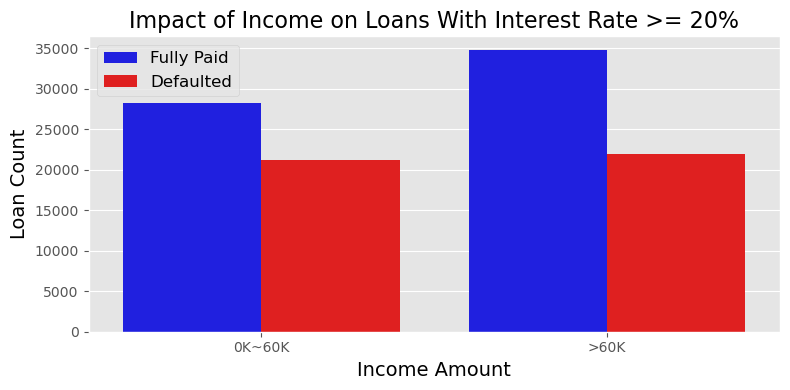

In [30]:
plt.figure(figsize=(8,4))
plt.style.use('default')
plt.style.use('ggplot')

#y=np.arange(len())

sns.countplot(data=a, x='Income Bin', 
              hue='Loan Outcome', 
              hue_order=['Fully Paid', 'Defaulted'], order = ['0K~60K', '>60K'],
              palette={'Defaulted':'red','Fully Paid':'blue'});#.set_xticklabels(['None', '0 to 1', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10+ Years'], rotation=45)

plt.title('Impact of Income on Loans With Interest Rate >= 20%', fontsize=16, color='black')
plt.xlabel('Income Amount', fontsize=14, color='black')
plt.ylabel('Loan Count', fontsize=14, color='black')
#plt.xticks(['Less than 10K', '10K~20K', '20K~30K', '30K~40K'])
#plt.yticks([])
plt.legend(fontsize=12, loc='upper left')
#plt.ticklabel_format(style='plain')

#plt.ylabel('Application Status', fontsize=14, color='blue')

#plt.text(10, 0.98, '9.4%', fontsize=10)

#plt.annotate('90%', xy=(10, 0.25), xytext=(10, 0.25),
            # arrowprops=dict(facecolor='black', shrink=0.05), fontsize=14)

#plt.annotate('0.7%', xy=(80000, 0.15), xytext=(90000, 0.25),
#             arrowprops=dict(facecolor='black', shrink=0.05), fontsize=14)

#plt.margins(x=0.15)
#plt.yticks(fontsize=12)

plt.tight_layout()
plt.show();

In [31]:
a[['Income Bin','Loan Outcome']].groupby('Income Bin').describe()

Loan Outcome                          
                  count unique         top   freq
Income Bin                                       
0K~60K            49405      2  Fully Paid  28252
>60K              56604      2  Fully Paid  34705

In [32]:
(49405-28252)/49405

0.42815504503592755

In [33]:
(56604-34705)/56604

0.3868807858101901

In [34]:
#Combine: Loan Amount < 9K & Income > 60K
chosen = a[(a['Loan Bin Special'] == '0K~9K') & (a['Income Bin'] == '>60K')] 
chosen['Loan Outcome'].value_counts()

Fully Paid    3684
Defaulted     1104
Name: Loan Outcome, dtype: int64

In [35]:
1104/(3684+1104)

0.23057644110275688

In [36]:
data = {'Fully Paid':[3684],
        'Defaulted':[1104]}

eda = pd.DataFrame(data)

eda

,Fully Paid,Defaulted
0,3684,1104


<Figure size 800x400 with 0 Axes>

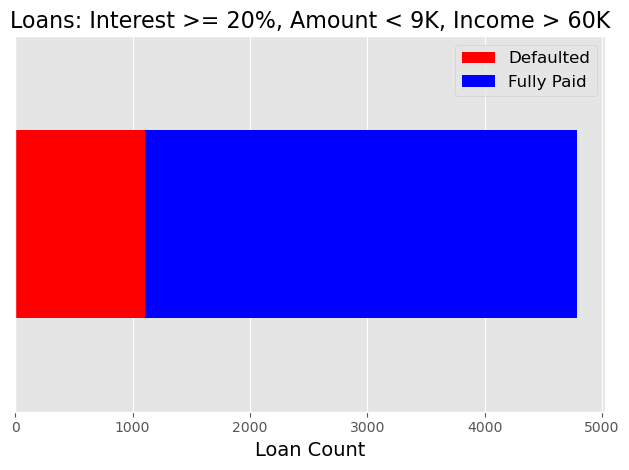

In [37]:
plt.figure(figsize=(8,4))
plt.style.use('default')
plt.style.use('ggplot')

#y=np.arange(len())

eda[['Defaulted', 'Fully Paid']].plot.barh(stacked=True, 
                                       color={'Defaulted':'Red',
                                              'Fully Paid':'Blue'}
                                       )


plt.title('Loans: Interest >= 20%, Amount < 9K, Income > 60K', fontsize=16, color='black')
plt.xlabel('Loan Count', fontsize=14, color='black')
#plt.ylabel('Loan Count', fontsize=14, color='black')
#plt.xticks(['Less than 10K', '10K~20K', '20K~30K', '30K~40K'])
plt.yticks([])
plt.legend(fontsize=12) #, loc='upper left')
#plt.ticklabel_format(style='plain')

#plt.ylabel('Application Status', fontsize=14, color='blue')

#plt.text(10, 0.98, '9.4%', fontsize=10)

#plt.annotate('90%', xy=(10, 0.25), xytext=(10, 0.25),
            # arrowprops=dict(facecolor='black', shrink=0.05), fontsize=14)

#plt.annotate('0.7%', xy=(80000, 0.15), xytext=(90000, 0.25),
#             arrowprops=dict(facecolor='black', shrink=0.05), fontsize=14)

#plt.margins(x=0.15)
#plt.yticks(fontsize=12)

plt.tight_layout()
plt.show();

In [38]:
#Overall Return On Investment If Invested In Loans > 20%, Amount < 9K, Income > 60K ==> 3.9%
chosen['total_pymnt_inv'].sum() / chosen['funded_amnt_inv'].sum()

1.0385382128473661

In [39]:
#Set up the data so it can be used for Logistic Regression: 
chosen.shape

(4788, 155)

In [40]:
imp_sub = chosen[['issue_d', 'loan_amnt', 'annual_inc', 'dti', 'fico_range_low', 'fico_range_high',
   'term', 'int_rate', 'installment', 'initial_list_status',
   'grade', 'sub_grade', 'emp_length', 'home_ownership',
   'earliest_cr_line', 'open_acc', 'total_acc',
   'revol_bal', 'revol_util',
   'inq_last_6mths', 'verification_status',
   
   'delinq_2yrs', 'mths_since_last_delinq','acc_now_delinq',
   'collections_12_mths_ex_med','tot_coll_amt', 'tot_cur_bal',
   'pub_rec', 'mths_since_last_record',
   
   
   'purpose', 'title', 'Loan Outcome', 
   'loan_status_bin']] 

In [41]:
imp_sub.shape

(4788, 33)

In [42]:
imp_sub.isna().sum().sort_values()

issue_d                          0
purpose                          0
pub_rec                          0
collections_12_mths_ex_med       0
acc_now_delinq                   0
delinq_2yrs                      0
verification_status              0
inq_last_6mths                   0
revol_bal                        0
Loan Outcome                     0
open_acc                         0
earliest_cr_line                 0
home_ownership                   0
total_acc                        0
sub_grade                        0
loan_amnt                        0
annual_inc                       0
dti                              0
fico_range_high                  0
term                             0
fico_range_low                   0
installment                      0
initial_list_status              0
grade                            0
int_rate                         0
loan_status_bin                  0
revol_util                      12
title                           31
tot_coll_amt        

In [43]:
#Let's add emp_length to the mix. Impute NaN with "None" string for time being: 

In [44]:
imp_sub['emp_length'].isna().sum()

137

In [45]:
imp_sub['emp_length'].replace(np.nan, "None", inplace=True)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [46]:
imp_sub['emp_length'].isna().sum()

0

In [47]:
imp_sub.isna().sum().sort_values()

issue_d                          0
purpose                          0
pub_rec                          0
collections_12_mths_ex_med       0
acc_now_delinq                   0
delinq_2yrs                      0
verification_status              0
inq_last_6mths                   0
revol_bal                        0
Loan Outcome                     0
open_acc                         0
earliest_cr_line                 0
home_ownership                   0
total_acc                        0
sub_grade                        0
loan_amnt                        0
annual_inc                       0
dti                              0
emp_length                       0
fico_range_high                  0
fico_range_low                   0
int_rate                         0
installment                      0
initial_list_status              0
grade                            0
term                             0
loan_status_bin                  0
revol_util                      12
title               

In [48]:
#Let's take a closer look at "mths_since_last_delinq":
imp_sub.mths_since_last_delinq.value_counts(dropna=False)

NaN     1813
12.0      83
10.0      74
19.0      72
20.0      68
9.0       68
7.0       63
6.0       62
14.0      61
18.0      61
23.0      60
21.0      57
5.0       57
16.0      56
13.0      56
22.0      56
26.0      55
17.0      54
11.0      53
28.0      53
33.0      53
24.0      52
8.0       51
27.0      51
31.0      50
4.0       50
35.0      50
15.0      49
45.0      47
29.0      45
3.0       45
25.0      43
34.0      41
43.0      41
40.0      40
32.0      40
44.0      40
30.0      39
38.0      38
48.0      37
2.0       36
37.0      36
47.0      36
36.0      36
39.0      36
46.0      31
42.0      31
68.0      30
41.0      28
52.0      27
53.0      27
49.0      27
55.0      24
69.0      24
56.0      24
67.0      22
79.0      21
80.0      20
73.0      20
50.0      19
63.0      19
62.0      18
54.0      18
59.0      17
60.0      17
72.0      17
51.0      17
76.0      17
65.0      17
64.0      16
57.0      16
71.0      15
74.0      15
77.0      15
58.0      14
66.0      14
1.0       13

In [49]:
#There are too many observations with missing values, NaN. We should drop this column/feature. 

In [50]:
imp_sub.isna().sum().sort_values()

issue_d                          0
purpose                          0
pub_rec                          0
collections_12_mths_ex_med       0
acc_now_delinq                   0
delinq_2yrs                      0
verification_status              0
inq_last_6mths                   0
revol_bal                        0
Loan Outcome                     0
open_acc                         0
earliest_cr_line                 0
home_ownership                   0
total_acc                        0
sub_grade                        0
loan_amnt                        0
annual_inc                       0
dti                              0
emp_length                       0
fico_range_high                  0
fico_range_low                   0
int_rate                         0
installment                      0
initial_list_status              0
grade                            0
term                             0
loan_status_bin                  0
revol_util                      12
title               

In [51]:
#For the time being, drop all other features with NAs....we don't know which ones are important.
#We also don't know what is the best way to "impute".
No_NA = imp_sub.dropna(axis=1)
No_NA

,issue_d,loan_amnt,annual_inc,dti,fico_range_low,fico_range_high,term,int_rate,installment,initial_list_status,grade,sub_grade,emp_length,home_ownership,earliest_cr_line,open_acc,total_acc,revol_bal,inq_last_6mths,verification_status,delinq_2yrs,acc_now_delinq,collections_12_mths_ex_med,pub_rec,purpose,Loan Outcome,loan_status_bin
10,Dec-2015,8775.0,75000.0,20.37,660.0,664.0,36 months,22.45,337.17,w,F,F1,10+ years,RENT,Sep-2006,14.0,44.0,7613.0,4.0,Source Verified,0.0,0.0,0.0,1.0,credit_card,Fully Paid,1.0
32,Dec-2015,3850.0,88000.0,6.23,715.0,719.0,36 months,21.48,146.00,w,E,E5,4 years,RENT,Mar-2007,8.0,11.0,23.0,3.0,Source Verified,1.0,0.0,0.0,0.0,home_improvement,Defaulted,0.0
48,Dec-2015,3225.0,65000.0,14.18,680.0,684.0,36 months,24.24,126.94,w,F,F3,< 1 year,MORTGAGE,Jan-1999,6.0,10.0,1793.0,2.0,Source Verified,0.0,0.0,0.0,0.0,debt_consolidation,Defaulted,0.0
65,Dec-2015,5800.0,90000.0,17.49,665.0,669.0,36 months,21.48,219.95,w,E,E5,4 years,MORTGAGE,Aug-2003,11.0,32.0,7476.0,5.0,Source Verified,4.0,0.0,0.0,1.0,small_business,Fully Paid,1.0
76,Dec-2015,8975.0,67000.0,21.53,755.0,759.0,36 months,21.48,340.35,w,E,E5,3 years,OWN,Jul-2009,6.0,23.0,0.0,3.0,Source Verified,0.0,0.0,0.0,0.0,moving,Fully Paid,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105857,Oct-2016,6400.0,85008.0,9.10,660.0,664.0,36 months,21.49,242.74,w,D,D5,2 years,MORTGAGE,Oct-2003,6.0,22.0,9068.0,1.0,Source Verified,0.0,0.0,0.0,0.0,other,Defaulted,0.0
105862,Oct-2016,4300.0,68000.0,1.50,685.0,689.0,36 months,25.69,172.55,f,F,F1,8 years,RENT,Oct-2006,11.0,15.0,1380.0,0.0,Verified,1.0,0.0,0.0,0.0,other,Defaulted,0.0
105934,Oct-2016,7000.0,150000.0,1.00,695.0,699.0,36 months,24.99,278.29,f,E,E4,None,OWN,Sep-2005,5.0,10.0,12269.0,0.0,Verified,0.0,0.0,0.0,0.0,home_improvement,Fully Paid,1.0
105946,Oct-2016,8000.0,72500.0,21.01,690.0,694.0,36 months,23.99,313.83,f,E,E2,4 years,MORTGAGE,Dec-1993,9.0,14.0,24928.0,1.0,Verified,0.0,0.0,0.0,0.0,other,Fully Paid,1.0


In [52]:
#We now have 27 features (includes target as well)
No_NA.shape

(4788, 27)

In [53]:
#Cross check that dataframe in use has no more Null values:
No_NA.isna().sum().sum()

0

In [54]:
data = No_NA.copy()

In [55]:
#Data Types of Remaining Features: 
data.dtypes

issue_d                        object
loan_amnt                     float64
annual_inc                    float64
dti                           float64
fico_range_low                float64
fico_range_high               float64
term                           object
int_rate                      float64
installment                   float64
initial_list_status            object
grade                          object
sub_grade                      object
emp_length                     object
home_ownership                 object
earliest_cr_line               object
open_acc                      float64
total_acc                     float64
revol_bal                     float64
inq_last_6mths                float64
verification_status            object
delinq_2yrs                   float64
acc_now_delinq                float64
collections_12_mths_ex_med    float64
pub_rec                       float64
purpose                        object
Loan Outcome                   object
loan_status_

In [56]:
#Return unique values of categorical columns:
{column: list(data[column].unique()) for column in data.columns if data.dtypes[column]=='object'}

{'issue_d': ['Dec-2015',
  'Nov-2015',
  'Oct-2015',
  'Sep-2015',
  'Aug-2015',
  'Jul-2015',
  'Jun-2015',
  'May-2015',
  'Apr-2015',
  'Mar-2015',
  'Feb-2015',
  'Jan-2015',
  'Mar-2018',
  'Feb-2018',
  'Jan-2018',
  'Sep-2017',
  'Aug-2017',
  'Jul-2017',
  'Jun-2016',
  'May-2016',
  'Apr-2016',
  'Sep-2018',
  'Aug-2018',
  'Jul-2018',
  'Jun-2017',
  'May-2017',
  'Apr-2017',
  'Mar-2016',
  'Feb-2016',
  'Jan-2016',
  'Dec-2014',
  'Nov-2014',
  'Oct-2014',
  'Sep-2014',
  'Aug-2014',
  'Jul-2014',
  'Jun-2014',
  'May-2014',
  'Apr-2014',
  'Mar-2014',
  'Feb-2014',
  'Jan-2014',
  'Dec-2018',
  'Nov-2018',
  'Oct-2018',
  'Jun-2018',
  'May-2018',
  'Apr-2018',
  'Dec-2011',
  'Nov-2011',
  'Oct-2011',
  'Sep-2011',
  'Aug-2011',
  'Jun-2011',
  'May-2011',
  'Feb-2011',
  'Jan-2011',
  'Dec-2010',
  'Mar-2017',
  'Feb-2017',
  'Jan-2017',
  'Dec-2013',
  'Nov-2013',
  'Oct-2013',
  'Sep-2013',
  'Aug-2013',
  'Jul-2013',
  'Jun-2013',
  'May-2013',
  'Apr-2013',
  'Mar-20

In [57]:
#A. Working with Date Columns First: 
date_columns = ['issue_d', 'earliest_cr_line']

In [58]:
data[date_columns]

,issue_d,earliest_cr_line
10,Dec-2015,Sep-2006
32,Dec-2015,Mar-2007
48,Dec-2015,Jan-1999
65,Dec-2015,Aug-2003
76,Dec-2015,Jul-2009
...,...,...
105857,Oct-2016,Oct-2003
105862,Oct-2016,Oct-2006
105934,Oct-2016,Sep-2005
105946,Oct-2016,Dec-1993


In [59]:
for column in date_columns:
    data[column + '_month'] = data[column].apply(lambda x: x[0:3])
    data[column + '_year'] = data[column].apply(lambda x: x[-4:])

In [60]:
data

,issue_d,loan_amnt,annual_inc,dti,fico_range_low,fico_range_high,term,int_rate,installment,initial_list_status,grade,sub_grade,emp_length,home_ownership,earliest_cr_line,open_acc,total_acc,revol_bal,inq_last_6mths,verification_status,delinq_2yrs,acc_now_delinq,collections_12_mths_ex_med,pub_rec,purpose,Loan Outcome,loan_status_bin,issue_d_month,issue_d_year,earliest_cr_line_month,earliest_cr_line_year
10,Dec-2015,8775.0,75000.0,20.37,660.0,664.0,36 months,22.45,337.17,w,F,F1,10+ years,RENT,Sep-2006,14.0,44.0,7613.0,4.0,Source Verified,0.0,0.0,0.0,1.0,credit_card,Fully Paid,1.0,Dec,2015,Sep,2006
32,Dec-2015,3850.0,88000.0,6.23,715.0,719.0,36 months,21.48,146.00,w,E,E5,4 years,RENT,Mar-2007,8.0,11.0,23.0,3.0,Source Verified,1.0,0.0,0.0,0.0,home_improvement,Defaulted,0.0,Dec,2015,Mar,2007
48,Dec-2015,3225.0,65000.0,14.18,680.0,684.0,36 months,24.24,126.94,w,F,F3,< 1 year,MORTGAGE,Jan-1999,6.0,10.0,1793.0,2.0,Source Verified,0.0,0.0,0.0,0.0,debt_consolidation,Defaulted,0.0,Dec,2015,Jan,1999
65,Dec-2015,5800.0,90000.0,17.49,665.0,669.0,36 months,21.48,219.95,w,E,E5,4 years,MORTGAGE,Aug-2003,11.0,32.0,7476.0,5.0,Source Verified,4.0,0.0,0.0,1.0,small_business,Fully Paid,1.0,Dec,2015,Aug,2003
76,Dec-2015,8975.0,67000.0,21.53,755.0,759.0,36 months,21.48,340.35,w,E,E5,3 years,OWN,Jul-2009,6.0,23.0,0.0,3.0,Source Verified,0.0,0.0,0.0,0.0,moving,Fully Paid,1.0,Dec,2015,Jul,2009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105857,Oct-2016,6400.0,85008.0,9.10,660.0,664.0,36 months,21.49,242.74,w,D,D5,2 years,MORTGAGE,Oct-2003,6.0,22.0,9068.0,1.0,Source Verified,0.0,0.0,0.0,0.0,other,Defaulted,0.0,Oct,2016,Oct,2003
105862,Oct-2016,4300.0,68000.0,1.50,685.0,689.0,36 months,25.69,172.55,f,F,F1,8 years,RENT,Oct-2006,11.0,15.0,1380.0,0.0,Verified,1.0,0.0,0.0,0.0,other,Defaulted,0.0,Oct,2016,Oct,2006
105934,Oct-2016,7000.0,150000.0,1.00,695.0,699.0,36 months,24.99,278.29,f,E,E4,None,OWN,Sep-2005,5.0,10.0,12269.0,0.0,Verified,0.0,0.0,0.0,0.0,home_improvement,Fully Paid,1.0,Oct,2016,Sep,2005
105946,Oct-2016,8000.0,72500.0,21.01,690.0,694.0,36 months,23.99,313.83,f,E,E2,4 years,MORTGAGE,Dec-1993,9.0,14.0,24928.0,1.0,Verified,0.0,0.0,0.0,0.0,other,Fully Paid,1.0,Oct,2016,Dec,1993


In [61]:
data = data.drop(date_columns, axis=1)
data.shape

(4788, 29)

In [62]:
month_ordering = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

In [63]:
for column in date_columns: 
    data[column + '_month'] = data[column + '_month'].apply(lambda x: month_ordering.index(x))

In [64]:
data

,loan_amnt,annual_inc,dti,fico_range_low,fico_range_high,term,int_rate,installment,initial_list_status,grade,sub_grade,emp_length,home_ownership,open_acc,total_acc,revol_bal,inq_last_6mths,verification_status,delinq_2yrs,acc_now_delinq,collections_12_mths_ex_med,pub_rec,purpose,Loan Outcome,loan_status_bin,issue_d_month,issue_d_year,earliest_cr_line_month,earliest_cr_line_year
10,8775.0,75000.0,20.37,660.0,664.0,36 months,22.45,337.17,w,F,F1,10+ years,RENT,14.0,44.0,7613.0,4.0,Source Verified,0.0,0.0,0.0,1.0,credit_card,Fully Paid,1.0,11,2015,8,2006
32,3850.0,88000.0,6.23,715.0,719.0,36 months,21.48,146.00,w,E,E5,4 years,RENT,8.0,11.0,23.0,3.0,Source Verified,1.0,0.0,0.0,0.0,home_improvement,Defaulted,0.0,11,2015,2,2007
48,3225.0,65000.0,14.18,680.0,684.0,36 months,24.24,126.94,w,F,F3,< 1 year,MORTGAGE,6.0,10.0,1793.0,2.0,Source Verified,0.0,0.0,0.0,0.0,debt_consolidation,Defaulted,0.0,11,2015,0,1999
65,5800.0,90000.0,17.49,665.0,669.0,36 months,21.48,219.95,w,E,E5,4 years,MORTGAGE,11.0,32.0,7476.0,5.0,Source Verified,4.0,0.0,0.0,1.0,small_business,Fully Paid,1.0,11,2015,7,2003
76,8975.0,67000.0,21.53,755.0,759.0,36 months,21.48,340.35,w,E,E5,3 years,OWN,6.0,23.0,0.0,3.0,Source Verified,0.0,0.0,0.0,0.0,moving,Fully Paid,1.0,11,2015,6,2009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105857,6400.0,85008.0,9.10,660.0,664.0,36 months,21.49,242.74,w,D,D5,2 years,MORTGAGE,6.0,22.0,9068.0,1.0,Source Verified,0.0,0.0,0.0,0.0,other,Defaulted,0.0,9,2016,9,2003
105862,4300.0,68000.0,1.50,685.0,689.0,36 months,25.69,172.55,f,F,F1,8 years,RENT,11.0,15.0,1380.0,0.0,Verified,1.0,0.0,0.0,0.0,other,Defaulted,0.0,9,2016,9,2006
105934,7000.0,150000.0,1.00,695.0,699.0,36 months,24.99,278.29,f,E,E4,None,OWN,5.0,10.0,12269.0,0.0,Verified,0.0,0.0,0.0,0.0,home_improvement,Fully Paid,1.0,9,2016,8,2005
105946,8000.0,72500.0,21.01,690.0,694.0,36 months,23.99,313.83,f,E,E2,4 years,MORTGAGE,9.0,14.0,24928.0,1.0,Verified,0.0,0.0,0.0,0.0,other,Fully Paid,1.0,9,2016,11,1993


In [65]:
for column in data.columns:
    try:
        data[column] = data[column].astype(np.float)
    except:
        pass

In [66]:
#Create new column of total months borrower has credit line upto loan issuance date:
data = data.assign(months_cr_line=(data['issue_d_year'] - data['earliest_cr_line_year'])*12+(data['issue_d_month']-data['earliest_cr_line_month']))            

In [67]:
data.drop(['issue_d_month', 'issue_d_year', 'earliest_cr_line_month', 'earliest_cr_line_year'], axis=1, inplace=True)
data.shape

(4788, 26)

In [68]:
data.dtypes

loan_amnt                     float64
annual_inc                    float64
dti                           float64
fico_range_low                float64
fico_range_high               float64
term                           object
int_rate                      float64
installment                   float64
initial_list_status            object
grade                          object
sub_grade                      object
emp_length                     object
home_ownership                 object
open_acc                      float64
total_acc                     float64
revol_bal                     float64
inq_last_6mths                float64
verification_status            object
delinq_2yrs                   float64
acc_now_delinq                float64
collections_12_mths_ex_med    float64
pub_rec                       float64
purpose                        object
Loan Outcome                   object
loan_status_bin               float64
months_cr_line                float64
dtype: objec

In [69]:
#Return unique values of categorical columns:
{column: list(data[column].unique()) for column in data.columns if data.dtypes[column]=='object'}

{'term': [' 36 months', ' 60 months'],
 'initial_list_status': ['w', 'f'],
 'grade': ['F', 'E', 'G', 'D'],
 'sub_grade': ['F1',
  'E5',
  'F3',
  'F5',
  'G2',
  'E4',
  'G1',
  'F2',
  'G3',
  'F4',
  'E2',
  'D4',
  'E3',
  'D5',
  'E1',
  'G4',
  'G5'],
 'emp_length': ['10+ years',
  '4 years',
  '< 1 year',
  '3 years',
  '6 years',
  '5 years',
  '7 years',
  '2 years',
  'None',
  '9 years',
  '1 year',
  '8 years'],
 'home_ownership': ['RENT', 'MORTGAGE', 'OWN', 'ANY'],
 'verification_status': ['Source Verified', 'Verified', 'Not Verified'],
 'purpose': ['credit_card',
  'home_improvement',
  'debt_consolidation',
  'small_business',
  'moving',
  'other',
  'medical',
  'house',
  'car',
  'major_purchase',
  'renewable_energy',
  'vacation',
  'wedding'],
 'Loan Outcome': ['Fully Paid', 'Defaulted']}

In [70]:
#Encoding Functions

def binary_temp(df, column, positive_value):
    temp_df = df.assign(new_be=df[column].apply(lambda x: 1 if x == positive_value else 0))
    return temp_df

def binary_encode(temp_df, column):
    new_df = temp_df.drop(column, axis=1)
    new_df = new_df.rename(columns={'new_be':column})
    return new_df
    
    #df[column + '_be'] = df[column].apply(lambda x: 1 if x == positive_value else 0)
    #df_new = pd.concat([df, df[column].apply(lambda x: 1 if x == positive_value else 0)], axis=1)
    #df_new = df_new.drop(column, axis=1)
    #return df_new

def ordinal_temp(df, column, ordering):
    temp_df = df.assign(new_oe=df[column].apply(lambda x: ordering.index(x)))
    return temp_df

def ordinal_encode(temp_df, column):
    new_df = temp_df.drop(column, axis=1)
    new_df = new_df.rename(columns={'new_oe':column})
    return new_df

def onehot_encode(df, column):
    dummies = pd.get_dummies(df[column])
    df_new = pd.concat([df, dummies], axis=1)
    df_new = df_new.drop(column, axis=1)
    return df_new

In [71]:
#Check Binary Encoding:
temp = binary_temp(data, 'term', ' 60 months')

In [72]:
#If ok, complete binary encoding:
new_df = binary_encode(temp, 'term')
new_df.head(5)

,loan_amnt,annual_inc,dti,fico_range_low,fico_range_high,int_rate,installment,initial_list_status,grade,sub_grade,emp_length,home_ownership,open_acc,total_acc,revol_bal,inq_last_6mths,verification_status,delinq_2yrs,acc_now_delinq,collections_12_mths_ex_med,pub_rec,purpose,Loan Outcome,loan_status_bin,months_cr_line,term
10,8775.0,75000.0,20.37,660.0,664.0,22.45,337.17,w,F,F1,10+ years,RENT,14.0,44.0,7613.0,4.0,Source Verified,0.0,0.0,0.0,1.0,credit_card,Fully Paid,1.0,111.0,0
32,3850.0,88000.0,6.23,715.0,719.0,21.48,146.00,w,E,E5,4 years,RENT,8.0,11.0,23.0,3.0,Source Verified,1.0,0.0,0.0,0.0,home_improvement,Defaulted,0.0,105.0,0
48,3225.0,65000.0,14.18,680.0,684.0,24.24,126.94,w,F,F3,< 1 year,MORTGAGE,6.0,10.0,1793.0,2.0,Source Verified,0.0,0.0,0.0,0.0,debt_consolidation,Defaulted,0.0,203.0,0
65,5800.0,90000.0,17.49,665.0,669.0,21.48,219.95,w,E,E5,4 years,MORTGAGE,11.0,32.0,7476.0,5.0,Source Verified,4.0,0.0,0.0,1.0,small_business,Fully Paid,1.0,148.0,0
76,8975.0,67000.0,21.53,755.0,759.0,21.48,340.35,w,E,E5,3 years,OWN,6.0,23.0,0.0,3.0,Source Verified,0.0,0.0,0.0,0.0,moving,Fully Paid,1.0,77.0,0


In [73]:
temp = binary_temp(new_df, 'initial_list_status', 'w')

In [74]:
new_df = binary_encode(temp, 'initial_list_status')
new_df.head(5)

,loan_amnt,annual_inc,dti,fico_range_low,fico_range_high,int_rate,installment,grade,sub_grade,emp_length,home_ownership,open_acc,total_acc,revol_bal,inq_last_6mths,verification_status,delinq_2yrs,acc_now_delinq,collections_12_mths_ex_med,pub_rec,purpose,Loan Outcome,loan_status_bin,months_cr_line,term,initial_list_status
10,8775.0,75000.0,20.37,660.0,664.0,22.45,337.17,F,F1,10+ years,RENT,14.0,44.0,7613.0,4.0,Source Verified,0.0,0.0,0.0,1.0,credit_card,Fully Paid,1.0,111.0,0,1
32,3850.0,88000.0,6.23,715.0,719.0,21.48,146.00,E,E5,4 years,RENT,8.0,11.0,23.0,3.0,Source Verified,1.0,0.0,0.0,0.0,home_improvement,Defaulted,0.0,105.0,0,1
48,3225.0,65000.0,14.18,680.0,684.0,24.24,126.94,F,F3,< 1 year,MORTGAGE,6.0,10.0,1793.0,2.0,Source Verified,0.0,0.0,0.0,0.0,debt_consolidation,Defaulted,0.0,203.0,0,1
65,5800.0,90000.0,17.49,665.0,669.0,21.48,219.95,E,E5,4 years,MORTGAGE,11.0,32.0,7476.0,5.0,Source Verified,4.0,0.0,0.0,1.0,small_business,Fully Paid,1.0,148.0,0,1
76,8975.0,67000.0,21.53,755.0,759.0,21.48,340.35,E,E5,3 years,OWN,6.0,23.0,0.0,3.0,Source Verified,0.0,0.0,0.0,0.0,moving,Fully Paid,1.0,77.0,0,1


In [75]:
grade_ordering = sorted(new_df['grade'].unique())
grade_ordering

['D', 'E', 'F', 'G']

In [76]:
temp_df = ordinal_temp(new_df, 'grade', grade_ordering)
temp_df[['grade', 'new_oe']]

,grade,new_oe
10,F,2
32,E,1
48,F,2
65,E,1
76,E,1
...,...,...
105857,D,0
105862,F,2
105934,E,1
105946,E,1


In [77]:
#If ok, complete ordinal encoding:
new_df = ordinal_encode(temp_df, 'grade')
new_df.head(5)

,loan_amnt,annual_inc,dti,fico_range_low,fico_range_high,int_rate,installment,sub_grade,emp_length,home_ownership,open_acc,total_acc,revol_bal,inq_last_6mths,verification_status,delinq_2yrs,acc_now_delinq,collections_12_mths_ex_med,pub_rec,purpose,Loan Outcome,loan_status_bin,months_cr_line,term,initial_list_status,grade
10,8775.0,75000.0,20.37,660.0,664.0,22.45,337.17,F1,10+ years,RENT,14.0,44.0,7613.0,4.0,Source Verified,0.0,0.0,0.0,1.0,credit_card,Fully Paid,1.0,111.0,0,1,2
32,3850.0,88000.0,6.23,715.0,719.0,21.48,146.00,E5,4 years,RENT,8.0,11.0,23.0,3.0,Source Verified,1.0,0.0,0.0,0.0,home_improvement,Defaulted,0.0,105.0,0,1,1
48,3225.0,65000.0,14.18,680.0,684.0,24.24,126.94,F3,< 1 year,MORTGAGE,6.0,10.0,1793.0,2.0,Source Verified,0.0,0.0,0.0,0.0,debt_consolidation,Defaulted,0.0,203.0,0,1,2
65,5800.0,90000.0,17.49,665.0,669.0,21.48,219.95,E5,4 years,MORTGAGE,11.0,32.0,7476.0,5.0,Source Verified,4.0,0.0,0.0,1.0,small_business,Fully Paid,1.0,148.0,0,1,1
76,8975.0,67000.0,21.53,755.0,759.0,21.48,340.35,E5,3 years,OWN,6.0,23.0,0.0,3.0,Source Verified,0.0,0.0,0.0,0.0,moving,Fully Paid,1.0,77.0,0,1,1


In [78]:
sub_grade_ordering = sorted(new_df['sub_grade'].unique())
sub_grade_ordering

['D4',
 'D5',
 'E1',
 'E2',
 'E3',
 'E4',
 'E5',
 'F1',
 'F2',
 'F3',
 'F4',
 'F5',
 'G1',
 'G2',
 'G3',
 'G4',
 'G5']

In [79]:
temp_df = ordinal_temp(new_df, 'sub_grade', sub_grade_ordering)
temp_df[['sub_grade', 'new_oe']]

,sub_grade,new_oe
10,F1,7
32,E5,6
48,F3,9
65,E5,6
76,E5,6
...,...,...
105857,D5,1
105862,F1,7
105934,E4,5
105946,E2,3


In [80]:
#If ok, complete ordinal encoding:
new_df = ordinal_encode(temp_df, 'sub_grade')
new_df.head(5)

,loan_amnt,annual_inc,dti,fico_range_low,fico_range_high,int_rate,installment,emp_length,home_ownership,open_acc,total_acc,revol_bal,inq_last_6mths,verification_status,delinq_2yrs,acc_now_delinq,collections_12_mths_ex_med,pub_rec,purpose,Loan Outcome,loan_status_bin,months_cr_line,term,initial_list_status,grade,sub_grade
10,8775.0,75000.0,20.37,660.0,664.0,22.45,337.17,10+ years,RENT,14.0,44.0,7613.0,4.0,Source Verified,0.0,0.0,0.0,1.0,credit_card,Fully Paid,1.0,111.0,0,1,2,7
32,3850.0,88000.0,6.23,715.0,719.0,21.48,146.00,4 years,RENT,8.0,11.0,23.0,3.0,Source Verified,1.0,0.0,0.0,0.0,home_improvement,Defaulted,0.0,105.0,0,1,1,6
48,3225.0,65000.0,14.18,680.0,684.0,24.24,126.94,< 1 year,MORTGAGE,6.0,10.0,1793.0,2.0,Source Verified,0.0,0.0,0.0,0.0,debt_consolidation,Defaulted,0.0,203.0,0,1,2,9
65,5800.0,90000.0,17.49,665.0,669.0,21.48,219.95,4 years,MORTGAGE,11.0,32.0,7476.0,5.0,Source Verified,4.0,0.0,0.0,1.0,small_business,Fully Paid,1.0,148.0,0,1,1,6
76,8975.0,67000.0,21.53,755.0,759.0,21.48,340.35,3 years,OWN,6.0,23.0,0.0,3.0,Source Verified,0.0,0.0,0.0,0.0,moving,Fully Paid,1.0,77.0,0,1,1,6


In [81]:
emp_ordering = [
    'None',
    '< 1 year',
    '1 year',
    '2 years',
    '3 years',
    '4 years',
    '5 years',
    '6 years',
    '7 years',
    '8 years',
    '9 years',
    '10+ years',
    ]

In [82]:
temp_df = ordinal_temp(new_df, 'emp_length', emp_ordering)
temp_df[['emp_length', 'new_oe']]

,emp_length,new_oe
10,10+ years,11
32,4 years,5
48,< 1 year,1
65,4 years,5
76,3 years,4
...,...,...
105857,2 years,3
105862,8 years,9
105934,None,0
105946,4 years,5


In [83]:
new_df = ordinal_encode(temp_df, 'emp_length')
new_df.head(3)

,loan_amnt,annual_inc,dti,fico_range_low,fico_range_high,int_rate,installment,home_ownership,open_acc,total_acc,revol_bal,inq_last_6mths,verification_status,delinq_2yrs,acc_now_delinq,collections_12_mths_ex_med,pub_rec,purpose,Loan Outcome,loan_status_bin,months_cr_line,term,initial_list_status,grade,sub_grade,emp_length
10,8775.0,75000.0,20.37,660.0,664.0,22.45,337.17,RENT,14.0,44.0,7613.0,4.0,Source Verified,0.0,0.0,0.0,1.0,credit_card,Fully Paid,1.0,111.0,0,1,2,7,11
32,3850.0,88000.0,6.23,715.0,719.0,21.48,146.00,RENT,8.0,11.0,23.0,3.0,Source Verified,1.0,0.0,0.0,0.0,home_improvement,Defaulted,0.0,105.0,0,1,1,6,5
48,3225.0,65000.0,14.18,680.0,684.0,24.24,126.94,MORTGAGE,6.0,10.0,1793.0,2.0,Source Verified,0.0,0.0,0.0,0.0,debt_consolidation,Defaulted,0.0,203.0,0,1,2,9,1


In [84]:
#Dummify nominal features:
numerical_df = onehot_encode(new_df, 'home_ownership')
numerical_df

,loan_amnt,annual_inc,dti,fico_range_low,fico_range_high,int_rate,installment,open_acc,total_acc,revol_bal,inq_last_6mths,verification_status,delinq_2yrs,acc_now_delinq,collections_12_mths_ex_med,pub_rec,purpose,Loan Outcome,loan_status_bin,months_cr_line,term,initial_list_status,grade,sub_grade,emp_length,ANY,MORTGAGE,OWN,RENT
10,8775.0,75000.0,20.37,660.0,664.0,22.45,337.17,14.0,44.0,7613.0,4.0,Source Verified,0.0,0.0,0.0,1.0,credit_card,Fully Paid,1.0,111.0,0,1,2,7,11,0,0,0,1
32,3850.0,88000.0,6.23,715.0,719.0,21.48,146.00,8.0,11.0,23.0,3.0,Source Verified,1.0,0.0,0.0,0.0,home_improvement,Defaulted,0.0,105.0,0,1,1,6,5,0,0,0,1
48,3225.0,65000.0,14.18,680.0,684.0,24.24,126.94,6.0,10.0,1793.0,2.0,Source Verified,0.0,0.0,0.0,0.0,debt_consolidation,Defaulted,0.0,203.0,0,1,2,9,1,0,1,0,0
65,5800.0,90000.0,17.49,665.0,669.0,21.48,219.95,11.0,32.0,7476.0,5.0,Source Verified,4.0,0.0,0.0,1.0,small_business,Fully Paid,1.0,148.0,0,1,1,6,5,0,1,0,0
76,8975.0,67000.0,21.53,755.0,759.0,21.48,340.35,6.0,23.0,0.0,3.0,Source Verified,0.0,0.0,0.0,0.0,moving,Fully Paid,1.0,77.0,0,1,1,6,4,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105857,6400.0,85008.0,9.10,660.0,664.0,21.49,242.74,6.0,22.0,9068.0,1.0,Source Verified,0.0,0.0,0.0,0.0,other,Defaulted,0.0,156.0,0,1,0,1,3,0,1,0,0
105862,4300.0,68000.0,1.50,685.0,689.0,25.69,172.55,11.0,15.0,1380.0,0.0,Verified,1.0,0.0,0.0,0.0,other,Defaulted,0.0,120.0,0,0,2,7,9,0,0,0,1
105934,7000.0,150000.0,1.00,695.0,699.0,24.99,278.29,5.0,10.0,12269.0,0.0,Verified,0.0,0.0,0.0,0.0,home_improvement,Fully Paid,1.0,133.0,0,0,1,5,0,0,0,1,0
105946,8000.0,72500.0,21.01,690.0,694.0,23.99,313.83,9.0,14.0,24928.0,1.0,Verified,0.0,0.0,0.0,0.0,other,Fully Paid,1.0,274.0,0,0,1,3,5,0,1,0,0


In [85]:
numerical_df2 = onehot_encode(numerical_df, 'purpose')
numerical_df2

,loan_amnt,annual_inc,dti,fico_range_low,fico_range_high,int_rate,installment,open_acc,total_acc,revol_bal,inq_last_6mths,verification_status,delinq_2yrs,acc_now_delinq,collections_12_mths_ex_med,pub_rec,Loan Outcome,loan_status_bin,months_cr_line,term,initial_list_status,grade,sub_grade,emp_length,ANY,MORTGAGE,OWN,RENT,car,credit_card,debt_consolidation,home_improvement,house,major_purchase,medical,moving,other,renewable_energy,small_business,vacation,wedding
10,8775.0,75000.0,20.37,660.0,664.0,22.45,337.17,14.0,44.0,7613.0,4.0,Source Verified,0.0,0.0,0.0,1.0,Fully Paid,1.0,111.0,0,1,2,7,11,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0
32,3850.0,88000.0,6.23,715.0,719.0,21.48,146.00,8.0,11.0,23.0,3.0,Source Verified,1.0,0.0,0.0,0.0,Defaulted,0.0,105.0,0,1,1,6,5,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
48,3225.0,65000.0,14.18,680.0,684.0,24.24,126.94,6.0,10.0,1793.0,2.0,Source Verified,0.0,0.0,0.0,0.0,Defaulted,0.0,203.0,0,1,2,9,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
65,5800.0,90000.0,17.49,665.0,669.0,21.48,219.95,11.0,32.0,7476.0,5.0,Source Verified,4.0,0.0,0.0,1.0,Fully Paid,1.0,148.0,0,1,1,6,5,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
76,8975.0,67000.0,21.53,755.0,759.0,21.48,340.35,6.0,23.0,0.0,3.0,Source Verified,0.0,0.0,0.0,0.0,Fully Paid,1.0,77.0,0,1,1,6,4,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105857,6400.0,85008.0,9.10,660.0,664.0,21.49,242.74,6.0,22.0,9068.0,1.0,Source Verified,0.0,0.0,0.0,0.0,Defaulted,0.0,156.0,0,1,0,1,3,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
105862,4300.0,68000.0,1.50,685.0,689.0,25.69,172.55,11.0,15.0,1380.0,0.0,Verified,1.0,0.0,0.0,0.0,Defaulted,0.0,120.0,0,0,2,7,9,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
105934,7000.0,150000.0,1.00,695.0,699.0,24.99,278.29,5.0,10.0,12269.0,0.0,Verified,0.0,0.0,0.0,0.0,Fully Paid,1.0,133.0,0,0,1,5,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
105946,8000.0,72500.0,21.01,690.0,694.0,23.99,313.83,9.0,14.0,24928.0,1.0,Verified,0.0,0.0,0.0,0.0,Fully Paid,1.0,274.0,0,0,1,3,5,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [86]:
numerical_df3 = onehot_encode(numerical_df2, 'verification_status')
numerical_df3

,loan_amnt,annual_inc,dti,fico_range_low,fico_range_high,int_rate,installment,open_acc,total_acc,revol_bal,inq_last_6mths,delinq_2yrs,acc_now_delinq,collections_12_mths_ex_med,pub_rec,Loan Outcome,loan_status_bin,months_cr_line,term,initial_list_status,grade,sub_grade,emp_length,ANY,MORTGAGE,OWN,RENT,car,credit_card,debt_consolidation,home_improvement,house,major_purchase,medical,moving,other,renewable_energy,small_business,vacation,wedding,Not Verified,Source Verified,Verified
10,8775.0,75000.0,20.37,660.0,664.0,22.45,337.17,14.0,44.0,7613.0,4.0,0.0,0.0,0.0,1.0,Fully Paid,1.0,111.0,0,1,2,7,11,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
32,3850.0,88000.0,6.23,715.0,719.0,21.48,146.00,8.0,11.0,23.0,3.0,1.0,0.0,0.0,0.0,Defaulted,0.0,105.0,0,1,1,6,5,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
48,3225.0,65000.0,14.18,680.0,684.0,24.24,126.94,6.0,10.0,1793.0,2.0,0.0,0.0,0.0,0.0,Defaulted,0.0,203.0,0,1,2,9,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
65,5800.0,90000.0,17.49,665.0,669.0,21.48,219.95,11.0,32.0,7476.0,5.0,4.0,0.0,0.0,1.0,Fully Paid,1.0,148.0,0,1,1,6,5,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
76,8975.0,67000.0,21.53,755.0,759.0,21.48,340.35,6.0,23.0,0.0,3.0,0.0,0.0,0.0,0.0,Fully Paid,1.0,77.0,0,1,1,6,4,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105857,6400.0,85008.0,9.10,660.0,664.0,21.49,242.74,6.0,22.0,9068.0,1.0,0.0,0.0,0.0,0.0,Defaulted,0.0,156.0,0,1,0,1,3,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
105862,4300.0,68000.0,1.50,685.0,689.0,25.69,172.55,11.0,15.0,1380.0,0.0,1.0,0.0,0.0,0.0,Defaulted,0.0,120.0,0,0,2,7,9,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
105934,7000.0,150000.0,1.00,695.0,699.0,24.99,278.29,5.0,10.0,12269.0,0.0,0.0,0.0,0.0,0.0,Fully Paid,1.0,133.0,0,0,1,5,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
105946,8000.0,72500.0,21.01,690.0,694.0,23.99,313.83,9.0,14.0,24928.0,1.0,0.0,0.0,0.0,0.0,Fully Paid,1.0,274.0,0,0,1,3,5,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1


In [87]:
numerical_df4 = numerical_df3.drop('Loan Outcome', axis=1)
numerical_df4

,loan_amnt,annual_inc,dti,fico_range_low,fico_range_high,int_rate,installment,open_acc,total_acc,revol_bal,inq_last_6mths,delinq_2yrs,acc_now_delinq,collections_12_mths_ex_med,pub_rec,loan_status_bin,months_cr_line,term,initial_list_status,grade,sub_grade,emp_length,ANY,MORTGAGE,OWN,RENT,car,credit_card,debt_consolidation,home_improvement,house,major_purchase,medical,moving,other,renewable_energy,small_business,vacation,wedding,Not Verified,Source Verified,Verified
10,8775.0,75000.0,20.37,660.0,664.0,22.45,337.17,14.0,44.0,7613.0,4.0,0.0,0.0,0.0,1.0,1.0,111.0,0,1,2,7,11,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
32,3850.0,88000.0,6.23,715.0,719.0,21.48,146.00,8.0,11.0,23.0,3.0,1.0,0.0,0.0,0.0,0.0,105.0,0,1,1,6,5,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
48,3225.0,65000.0,14.18,680.0,684.0,24.24,126.94,6.0,10.0,1793.0,2.0,0.0,0.0,0.0,0.0,0.0,203.0,0,1,2,9,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
65,5800.0,90000.0,17.49,665.0,669.0,21.48,219.95,11.0,32.0,7476.0,5.0,4.0,0.0,0.0,1.0,1.0,148.0,0,1,1,6,5,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
76,8975.0,67000.0,21.53,755.0,759.0,21.48,340.35,6.0,23.0,0.0,3.0,0.0,0.0,0.0,0.0,1.0,77.0,0,1,1,6,4,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105857,6400.0,85008.0,9.10,660.0,664.0,21.49,242.74,6.0,22.0,9068.0,1.0,0.0,0.0,0.0,0.0,0.0,156.0,0,1,0,1,3,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
105862,4300.0,68000.0,1.50,685.0,689.0,25.69,172.55,11.0,15.0,1380.0,0.0,1.0,0.0,0.0,0.0,0.0,120.0,0,0,2,7,9,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
105934,7000.0,150000.0,1.00,695.0,699.0,24.99,278.29,5.0,10.0,12269.0,0.0,0.0,0.0,0.0,0.0,1.0,133.0,0,0,1,5,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
105946,8000.0,72500.0,21.01,690.0,694.0,23.99,313.83,9.0,14.0,24928.0,1.0,0.0,0.0,0.0,0.0,1.0,274.0,0,0,1,3,5,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1


In [88]:
numerical_df4.dtypes

loan_amnt                     float64
annual_inc                    float64
dti                           float64
fico_range_low                float64
fico_range_high               float64
int_rate                      float64
installment                   float64
open_acc                      float64
total_acc                     float64
revol_bal                     float64
inq_last_6mths                float64
delinq_2yrs                   float64
acc_now_delinq                float64
collections_12_mths_ex_med    float64
pub_rec                       float64
loan_status_bin               float64
months_cr_line                float64
term                            int64
initial_list_status             int64
grade                           int64
sub_grade                       int64
emp_length                      int64
ANY                             uint8
MORTGAGE                        uint8
OWN                             uint8
RENT                            uint8
car         

In [89]:
#Return unique values of categorical columns:
{column: list(numerical_df4[column].unique()) for column in numerical_df4.columns if numerical_df4.dtypes[column]=='object'}

{}

In [90]:
numerical_df4 = numerical_df4.reset_index(drop=True)

In [91]:
numerical_df4.shape

(4788, 42)

In [92]:
unscaled = numerical_df4

In [93]:
unscaled

,loan_amnt,annual_inc,dti,fico_range_low,fico_range_high,int_rate,installment,open_acc,total_acc,revol_bal,inq_last_6mths,delinq_2yrs,acc_now_delinq,collections_12_mths_ex_med,pub_rec,loan_status_bin,months_cr_line,term,initial_list_status,grade,sub_grade,emp_length,ANY,MORTGAGE,OWN,RENT,car,credit_card,debt_consolidation,home_improvement,house,major_purchase,medical,moving,other,renewable_energy,small_business,vacation,wedding,Not Verified,Source Verified,Verified
0,8775.0,75000.0,20.37,660.0,664.0,22.45,337.17,14.0,44.0,7613.0,4.0,0.0,0.0,0.0,1.0,1.0,111.0,0,1,2,7,11,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,3850.0,88000.0,6.23,715.0,719.0,21.48,146.00,8.0,11.0,23.0,3.0,1.0,0.0,0.0,0.0,0.0,105.0,0,1,1,6,5,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
2,3225.0,65000.0,14.18,680.0,684.0,24.24,126.94,6.0,10.0,1793.0,2.0,0.0,0.0,0.0,0.0,0.0,203.0,0,1,2,9,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
3,5800.0,90000.0,17.49,665.0,669.0,21.48,219.95,11.0,32.0,7476.0,5.0,4.0,0.0,0.0,1.0,1.0,148.0,0,1,1,6,5,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
4,8975.0,67000.0,21.53,755.0,759.0,21.48,340.35,6.0,23.0,0.0,3.0,0.0,0.0,0.0,0.0,1.0,77.0,0,1,1,6,4,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4783,6400.0,85008.0,9.10,660.0,664.0,21.49,242.74,6.0,22.0,9068.0,1.0,0.0,0.0,0.0,0.0,0.0,156.0,0,1,0,1,3,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
4784,4300.0,68000.0,1.50,685.0,689.0,25.69,172.55,11.0,15.0,1380.0,0.0,1.0,0.0,0.0,0.0,0.0,120.0,0,0,2,7,9,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
4785,7000.0,150000.0,1.00,695.0,699.0,24.99,278.29,5.0,10.0,12269.0,0.0,0.0,0.0,0.0,0.0,1.0,133.0,0,0,1,5,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
4786,8000.0,72500.0,21.01,690.0,694.0,23.99,313.83,9.0,14.0,24928.0,1.0,0.0,0.0,0.0,0.0,1.0,274.0,0,0,1,3,5,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1


In [94]:
#Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

In [95]:
X = numerical_df4.drop('loan_status_bin', axis=1)
y = numerical_df4['loan_status_bin']

In [96]:
X

,loan_amnt,annual_inc,dti,fico_range_low,fico_range_high,int_rate,installment,open_acc,total_acc,revol_bal,inq_last_6mths,delinq_2yrs,acc_now_delinq,collections_12_mths_ex_med,pub_rec,months_cr_line,term,initial_list_status,grade,sub_grade,emp_length,ANY,MORTGAGE,OWN,RENT,car,credit_card,debt_consolidation,home_improvement,house,major_purchase,medical,moving,other,renewable_energy,small_business,vacation,wedding,Not Verified,Source Verified,Verified
0,8775.0,75000.0,20.37,660.0,664.0,22.45,337.17,14.0,44.0,7613.0,4.0,0.0,0.0,0.0,1.0,111.0,0,1,2,7,11,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,3850.0,88000.0,6.23,715.0,719.0,21.48,146.00,8.0,11.0,23.0,3.0,1.0,0.0,0.0,0.0,105.0,0,1,1,6,5,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
2,3225.0,65000.0,14.18,680.0,684.0,24.24,126.94,6.0,10.0,1793.0,2.0,0.0,0.0,0.0,0.0,203.0,0,1,2,9,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
3,5800.0,90000.0,17.49,665.0,669.0,21.48,219.95,11.0,32.0,7476.0,5.0,4.0,0.0,0.0,1.0,148.0,0,1,1,6,5,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
4,8975.0,67000.0,21.53,755.0,759.0,21.48,340.35,6.0,23.0,0.0,3.0,0.0,0.0,0.0,0.0,77.0,0,1,1,6,4,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4783,6400.0,85008.0,9.10,660.0,664.0,21.49,242.74,6.0,22.0,9068.0,1.0,0.0,0.0,0.0,0.0,156.0,0,1,0,1,3,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
4784,4300.0,68000.0,1.50,685.0,689.0,25.69,172.55,11.0,15.0,1380.0,0.0,1.0,0.0,0.0,0.0,120.0,0,0,2,7,9,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
4785,7000.0,150000.0,1.00,695.0,699.0,24.99,278.29,5.0,10.0,12269.0,0.0,0.0,0.0,0.0,0.0,133.0,0,0,1,5,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
4786,8000.0,72500.0,21.01,690.0,694.0,23.99,313.83,9.0,14.0,24928.0,1.0,0.0,0.0,0.0,0.0,274.0,0,0,1,3,5,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1


In [97]:
y

0       1.0
1       0.0
2       0.0
3       1.0
4       1.0
       ... 
4783    0.0
4784    0.0
4785    1.0
4786    1.0
4787    1.0
Name: loan_status_bin, Length: 4788, dtype: float64

In [98]:
X_scaled = sc.fit_transform(X)

In [99]:
X = pd.DataFrame(X_scaled, columns=X.columns)
X

,loan_amnt,annual_inc,dti,fico_range_low,fico_range_high,int_rate,installment,open_acc,total_acc,revol_bal,inq_last_6mths,delinq_2yrs,acc_now_delinq,collections_12_mths_ex_med,pub_rec,months_cr_line,term,initial_list_status,grade,sub_grade,emp_length,ANY,MORTGAGE,OWN,RENT,car,credit_card,debt_consolidation,home_improvement,house,major_purchase,medical,moving,other,renewable_energy,small_business,vacation,wedding,Not Verified,Source Verified,Verified
0,1.738898,-0.182527,0.400638,-0.972492,-0.972492,-0.163114,1.762586,0.419585,1.498572,-0.314370,2.025625,-0.449462,-0.076696,-0.151385,1.017895,-0.901444,-0.227696,1.412222,1.395096,0.923513,0.991772,-0.032332,-0.914655,-0.349428,1.140534,-0.125291,4.004890,-0.763077,-0.295285,-0.143798,-0.19128,-0.222058,-0.218933,-0.558052,-0.063119,-0.223091,-0.184125,-0.088249,-0.572848,1.254117,-0.756922
1,-0.584556,-0.058123,-1.179441,1.937525,1.937525,-0.577803,-0.584252,-0.595731,-1.066401,-0.687793,1.256559,0.436874,-0.076696,-0.151385,-0.405909,-0.972438,-0.227696,1.412222,0.013276,0.599644,-0.597631,-0.032332,-0.914655,-0.349428,1.140534,-0.125291,-0.249695,-0.763077,3.386554,-0.143798,-0.19128,-0.222058,-0.218933,-0.558052,-0.063119,-0.223091,-0.184125,-0.088249,-0.572848,1.254117,-0.756922
2,-0.879411,-0.278223,-0.291066,0.085696,0.085696,0.602136,-0.818236,-0.934170,-1.144127,-0.600710,0.487493,-0.449462,-0.076696,-0.151385,-0.405909,0.187142,-0.227696,1.412222,1.395096,1.571250,-1.657233,-0.032332,1.093308,-0.349428,-0.876783,-0.125291,-0.249695,1.310483,-0.295285,-0.143798,-0.19128,-0.222058,-0.218933,-0.558052,-0.063119,-0.223091,-0.184125,-0.088249,-0.572848,1.254117,-0.756922
3,0.335390,-0.038984,0.078811,-0.707945,-0.707945,-0.577803,0.323572,-0.088073,0.565854,-0.321111,2.794691,3.095885,-0.076696,-0.151385,1.017895,-0.463643,-0.227696,1.412222,0.013276,0.599644,-0.597631,-0.032332,1.093308,-0.349428,-0.876783,-0.125291,-0.249695,-0.763077,-0.295285,-0.143798,-0.19128,-0.222058,-0.218933,-0.558052,-0.063119,4.482467,-0.184125,-0.088249,-0.572848,1.254117,-0.756922
4,1.833252,-0.259084,0.530262,4.053900,4.053900,-0.577803,1.801624,-0.934170,-0.133684,-0.688924,1.256559,-0.449462,-0.076696,-0.151385,-0.405909,-1.303747,-0.227696,1.412222,0.013276,0.599644,-0.862531,-0.032332,-0.914655,2.861821,-0.876783,-0.125291,-0.249695,-0.763077,-0.295285,-0.143798,-0.19128,-0.222058,4.567605,-0.558052,-0.063119,-0.223091,-0.184125,-0.088249,-0.572848,1.254117,-0.756922
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4783,0.618451,-0.086755,-0.858732,-0.972492,-0.972492,-0.573528,0.603346,-0.934170,-0.211410,-0.242785,-0.281573,-0.449462,-0.076696,-0.151385,-0.405909,-0.368983,-0.227696,1.412222,-1.368545,-1.019699,-1.127432,-0.032332,1.093308,-0.349428,-0.876783,-0.125291,-0.249695,-0.763077,-0.295285,-0.143798,-0.19128,-0.222058,-0.218933,1.791949,-0.063119,-0.223091,-0.184125,-0.088249,-0.572848,1.254117,-0.756922
4784,-0.372261,-0.249514,-1.707996,0.350243,0.350243,1.222032,-0.258319,-0.088073,-0.755495,-0.621029,-1.050639,0.436874,-0.076696,-0.151385,-0.405909,-0.794952,-0.227696,-0.708104,1.395096,0.923513,0.461971,-0.032332,-0.914655,-0.349428,1.140534,-0.125291,-0.249695,-0.763077,-0.295285,-0.143798,-0.19128,-0.222058,-0.218933,1.791949,-0.063119,-0.223091,-0.184125,-0.088249,-0.572848,-0.797374,1.321141
4785,0.901511,0.535191,-1.763869,0.879337,0.879337,0.922772,1.039764,-1.103389,-1.144127,-0.085299,-1.050639,-0.449462,-0.076696,-0.151385,-0.405909,-0.641130,-0.227696,-0.708104,0.013276,0.275775,-1.922133,-0.032332,-0.914655,2.861821,-0.876783,-0.125291,-0.249695,-0.763077,3.386554,-0.143798,-0.19128,-0.222058,-0.218933,-0.558052,-0.063119,-0.223091,-0.184125,-0.088249,-0.572848,-0.797374,1.321141
4786,1.373279,-0.206451,0.472155,0.614790,0.614790,0.495258,1.476060,-0.426512,-0.833222,0.537515,-0.281573,-0.449462,-0.076696,-0.151385,-0.405909,1.027246,-0.227696,-

In [100]:
scaled = pd.concat([X,y], axis=1)
scaled

,loan_amnt,annual_inc,dti,fico_range_low,fico_range_high,int_rate,installment,open_acc,total_acc,revol_bal,inq_last_6mths,delinq_2yrs,acc_now_delinq,collections_12_mths_ex_med,pub_rec,months_cr_line,term,initial_list_status,grade,sub_grade,emp_length,ANY,MORTGAGE,OWN,RENT,car,credit_card,debt_consolidation,home_improvement,house,major_purchase,medical,moving,other,renewable_energy,small_business,vacation,wedding,Not Verified,Source Verified,Verified,loan_status_bin
0,1.738898,-0.182527,0.400638,-0.972492,-0.972492,-0.163114,1.762586,0.419585,1.498572,-0.314370,2.025625,-0.449462,-0.076696,-0.151385,1.017895,-0.901444,-0.227696,1.412222,1.395096,0.923513,0.991772,-0.032332,-0.914655,-0.349428,1.140534,-0.125291,4.004890,-0.763077,-0.295285,-0.143798,-0.19128,-0.222058,-0.218933,-0.558052,-0.063119,-0.223091,-0.184125,-0.088249,-0.572848,1.254117,-0.756922,1.0
1,-0.584556,-0.058123,-1.179441,1.937525,1.937525,-0.577803,-0.584252,-0.595731,-1.066401,-0.687793,1.256559,0.436874,-0.076696,-0.151385,-0.405909,-0.972438,-0.227696,1.412222,0.013276,0.599644,-0.597631,-0.032332,-0.914655,-0.349428,1.140534,-0.125291,-0.249695,-0.763077,3.386554,-0.143798,-0.19128,-0.222058,-0.218933,-0.558052,-0.063119,-0.223091,-0.184125,-0.088249,-0.572848,1.254117,-0.756922,0.0
2,-0.879411,-0.278223,-0.291066,0.085696,0.085696,0.602136,-0.818236,-0.934170,-1.144127,-0.600710,0.487493,-0.449462,-0.076696,-0.151385,-0.405909,0.187142,-0.227696,1.412222,1.395096,1.571250,-1.657233,-0.032332,1.093308,-0.349428,-0.876783,-0.125291,-0.249695,1.310483,-0.295285,-0.143798,-0.19128,-0.222058,-0.218933,-0.558052,-0.063119,-0.223091,-0.184125,-0.088249,-0.572848,1.254117,-0.756922,0.0
3,0.335390,-0.038984,0.078811,-0.707945,-0.707945,-0.577803,0.323572,-0.088073,0.565854,-0.321111,2.794691,3.095885,-0.076696,-0.151385,1.017895,-0.463643,-0.227696,1.412222,0.013276,0.599644,-0.597631,-0.032332,1.093308,-0.349428,-0.876783,-0.125291,-0.249695,-0.763077,-0.295285,-0.143798,-0.19128,-0.222058,-0.218933,-0.558052,-0.063119,4.482467,-0.184125,-0.088249,-0.572848,1.254117,-0.756922,1.0
4,1.833252,-0.259084,0.530262,4.053900,4.053900,-0.577803,1.801624,-0.934170,-0.133684,-0.688924,1.256559,-0.449462,-0.076696,-0.151385,-0.405909,-1.303747,-0.227696,1.412222,0.013276,0.599644,-0.862531,-0.032332,-0.914655,2.861821,-0.876783,-0.125291,-0.249695,-0.763077,-0.295285,-0.143798,-0.19128,-0.222058,4.567605,-0.558052,-0.063119,-0.223091,-0.184125,-0.088249,-0.572848,1.254117,-0.756922,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4783,0.618451,-0.086755,-0.858732,-0.972492,-0.972492,-0.573528,0.603346,-0.934170,-0.211410,-0.242785,-0.281573,-0.449462,-0.076696,-0.151385,-0.405909,-0.368983,-0.227696,1.412222,-1.368545,-1.019699,-1.127432,-0.032332,1.093308,-0.349428,-0.876783,-0.125291,-0.249695,-0.763077,-0.295285,-0.143798,-0.19128,-0.222058,-0.218933,1.791949,-0.063119,-0.223091,-0.184125,-0.088249,-0.572848,1.254117,-0.756922,0.0
4784,-0.372261,-0.249514,-1.707996,0.350243,0.350243,1.222032,-0.258319,-0.088073,-0.755495,-0.621029,-1.050639,0.436874,-0.076696,-0.151385,-0.405909,-0.794952,-0.227696,-0.708104,1.395096,0.923513,0.461971,-0.032332,-0.914655,-0.349428,1.140534,-0.125291,-0.249695,-0.763077,-0.295285,-0.143798,-0.19128,-0.222058,-0.218933,1.791949,-0.063119,-0.223091,-0.184125,-0.088249,-0.572848,-0.797374,1.321141,0.0
4785,0.901511,0.535191,-1.763869,0.879337,0.879337,0.922772,1.039764,-1.103389,-1.144127,-0.085299,-1.050639,-0.449462,-0.076696,-0.151385,-0.405909,-0.641130,-0.227696,-0.708104,0.013276,0.275775,-1.922133,-0.032332,-0.914655,2.861821,-0.876783,-0.125291,-0.249695,-0.763077,3.386554,-0.143798,-0.19128,-0.222058,-0.218933,-0.558052,-0.063119,-0.223091,-0.184125,-0.088249,-0.572848,-0.797374,1.321141,1.0
4786,1.373279,-0.206451,0.472155,0.614790,0.614790,0.495258,1.476060,-0.426512,-0.833222,0.537515,-0.281573,-0.44946

In [101]:
scaled.loan_status_bin.value_counts()
#0 = Defaulted Loans
#1 = Loans Paid In Full

1.0    3684
0.0    1104
Name: loan_status_bin, dtype: int64

In [102]:
X = scaled.drop('loan_status_bin', axis=1)
X.shape

(4788, 41)

In [103]:
y = scaled['loan_status_bin']

In [104]:
lr1 = LogisticRegression()

In [105]:
steps = [('model', lr1)]
pipeline = Pipeline(steps=steps)

In [106]:
#Accuracy:

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)
scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1) 
print(scores)

score = np.mean(scores)
print(score)

[0.77453027 0.76409186 0.76826722 0.77220481 0.76698015]
0.7692148611592856


In [107]:
#Aggregated Confusion Matrix From RepeatedStratifiedKFold: 
y_pred = cross_val_predict(pipeline, X, y, cv=cv, n_jobs=-1)
conf_mat = confusion_matrix(y, y_pred)
conf_mat

array([[  35, 1069],
       [  36, 3648]])

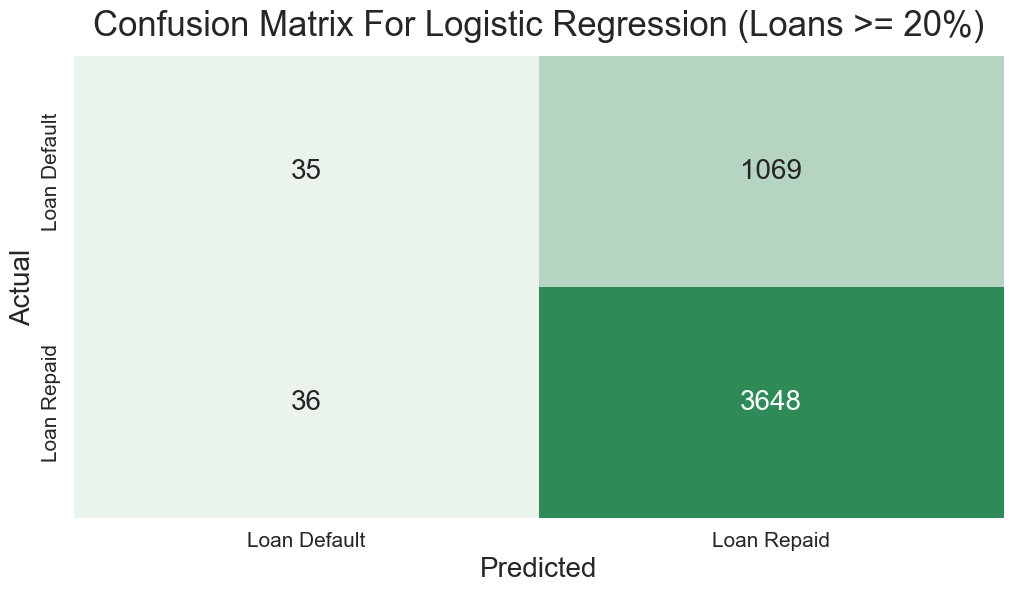

In [108]:
sns.set(rc = {'figure.figsize':(12,6)})
#cmap = sns.cubehelix_palette(start=2, rot=0, dark=0, light=.95, reverse=True, as_cmap=True)
cmap = sns.light_palette('seagreen', as_cmap=True)

res = sns.heatmap(conf_mat, annot=True, fmt='d', annot_kws={"size":20},
#            xticklabels = ['Good = Paid In Full', 'Bad = Default'],
#            yticklabels = ['Loan Paid In Full', 'Bad = Default'], 
            cmap=cmap, cbar=False)

res.set_xticklabels(['Loan Default', 'Loan Repaid'], fontsize=15)
res.set_yticklabels(['Loan Default', 'Loan Repaid'], fontsize=15)


plt.title('Confusion Matrix For Logistic Regression (Loans >= 20%)', fontsize=25, pad=15)
plt.xlabel('Predicted', fontsize=20)
plt.ylabel('Actual', fontsize=20);

In [109]:
accuracy_score(y, y_pred)

0.7692147034252298

In [110]:
precision_score(y, y_pred)

0.773372906508374

In [111]:
#Accuracy
TN, FP, FN, TP = conf_mat.ravel()
print(TP)
print(FP)
print(FN)
print(TN)
print((TP + TN) / (TN + TP + FP + FN))

3648
1069
36
35
0.7692147034252298


In [112]:
#Precision
TP / (TP+FP)

0.773372906508374

In [113]:
#Re-examine original pool of accepted LC Loans: 

print(data.loan_status_bin.value_counts())
#0 = Loan Defaulted
#1 = Loan Fully Paid

good_loan = data.loan_status_bin.value_counts()[1]
bad_loan = data.loan_status_bin.value_counts()[0]

print()
print(good_loan / (good_loan + bad_loan))

#Random investment would give us 59% chance of pickkng a good loan

1.0    3684
0.0    1104
Name: loan_status_bin, dtype: int64

0.7694235588972431


In [114]:
#Positive Predictive Value (or Precision)
#Logistic Model only does 1.1% better than Null Model or "random investment"
TP / (TP+FP)

0.773372906508374

In [115]:
#What if we "balance" the weight class to avoid "imbalanced" nature...No Change! 

In [116]:
lr_balanced = LogisticRegression(class_weight='balanced')

In [117]:
steps_balanced = [('model', lr_balanced)]
pipeline_balanced = Pipeline(steps=steps)

In [118]:
#Accuracy:

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)
scores = cross_val_score(pipeline_balanced, X, y, scoring='accuracy', cv=cv, n_jobs=-1) 
print(scores)

score = np.mean(scores)
print(score)

[0.77453027 0.76409186 0.76826722 0.77220481 0.76698015]
0.7692148611592856


In [119]:
#Aggregated Confusion Matrix From RepeatedStratifiedKFold: 
y_pred_balanced = cross_val_predict(pipeline_balanced, X, y, cv=cv, n_jobs=-1)
conf_mat_balanced = confusion_matrix(y, y_pred_balanced)
conf_mat_balanced

array([[  35, 1069],
       [  36, 3648]])

In [120]:
#Obtain predicted probabilities (not predicted classes) from RSKF: 
y_pred_prob = cross_val_predict(pipeline, X, y, cv=cv, n_jobs=-1, method='predict_proba')

In [121]:
y_pred_prob

array([[0.49406563, 0.50593437],
       [0.265968  , 0.734032  ],
       [0.28514401, 0.71485599],
       ...,
       [0.25935359, 0.74064641],
       [0.3012406 , 0.6987594 ],
       [0.38208896, 0.61791104]])

In [122]:
#Obtaining classification based on desired threshold of 0.5 (Same as standard Logistic Regression): 

y_pred_success = (y_pred_prob[:, 1] > 0.50).astype('float')
y_pred_success

array([1., 1., 1., ..., 1., 1., 1.])

In [123]:
conf_mat = confusion_matrix(y, y_pred_success)
conf_mat

array([[  35, 1069],
       [  36, 3648]])

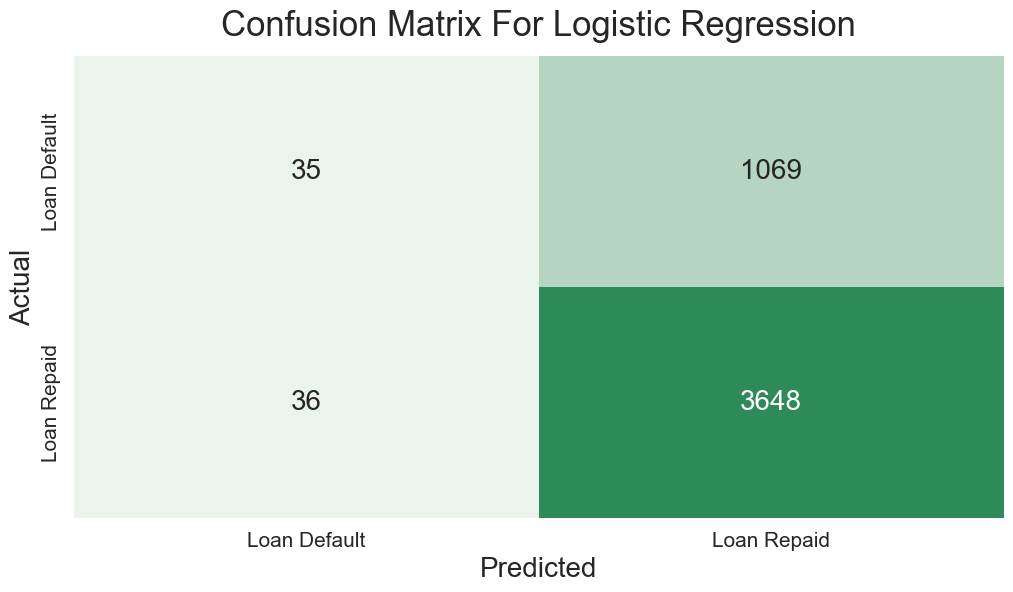

In [124]:
sns.set(rc = {'figure.figsize':(12,6)})
#cmap = sns.cubehelix_palette(start=2, rot=0, dark=0, light=.95, reverse=True, as_cmap=True)
cmap = sns.light_palette('seagreen', as_cmap=True)

res = sns.heatmap(conf_mat, annot=True, fmt='d', annot_kws={"size":20},
#            xticklabels = ['Good = Paid In Full', 'Bad = Default'],
#            yticklabels = ['Loan Paid In Full', 'Bad = Default'], 
            cmap=cmap, cbar=False)

res.set_xticklabels(['Loan Default', 'Loan Repaid'], fontsize=15)
res.set_yticklabels(['Loan Default', 'Loan Repaid'], fontsize=15)


plt.title('Confusion Matrix For Logistic Regression', fontsize=25, pad=15)
plt.xlabel('Predicted', fontsize=20)
plt.ylabel('Actual', fontsize=20);

In [125]:
accuracy_score(y, y_pred_success)

0.7692147034252298

In [126]:
TN, FP, FN, TP = conf_mat.ravel()
print(TP)
print(FP)
print(FN)
print(TN)
print((TP + TN) / (TN + TP + FP + FN))

3648
1069
36
35
0.7692147034252298


In [127]:
#Adding Logistic Regression Predictions to loans >= 20%
chosen['Predicted'] = y_pred_success

/var/folders/kl/4xt5tydd0xb8yvwkgnx2mnc00000gn/T/ipykernel_11679/577577786.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chosen['Predicted'] = y_pred_success


In [128]:
chosen.shape

(4788, 156)

In [129]:
chosen.head(10)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,Loan Outcome,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term,loan_status_bin,Loan Bin,Loan Bin Special,Income Bin,Predicted
10,68537123,NaN,8775.0,8775.0,8775.0,36 months,22.45,337.17,F,F1,Service Rep,10+ years,RENT,75000.0,Source Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.action?loan_id=68537123,NaN,credit_card,Credit card refinancing,308xx,GA,20.37,0.0,Sep-2006,660.0,664.0,4.0,60.0,65.0,14.0,1.0,7613.0,33.4,44.0,w,0.0,0.0,9369.550000,9369.55,8775.00,594.55,0.0,0.00,0.0000,Apr-2016,8717.10,NaN,Mar-2019,654.0,650.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,328.0,65963.0,3.0,2.0,1.0,5.0,1.0,58350.0,69.0,5.0,13.0,3737.0,51.0,22800.0,16.0,2.0,16.0,18.0,4712.0,957.0,87.7,0.0,0.0,111.0,102.0,0.0,0.0,0.0,2.0,60.0,0.0,60.0,0.0,5.0,6.0,5.0,13.0,19.0,12.0,25.0,6.0,14.0,0.0,0.0,0.0,6.0,95.5,60.0,0.0,1.0,87952.0,65963.0,7800.0,65152.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0K~10K,0K~9K,>60K,1.0
32,68406357,NaN,3850.0,3850.0,3850.0,36 months,21.48,146.00,E,E5,Project Manager,4 years,RENT,88000.0,Source Verified,Dec-2015,Defaulted,n,https://lendingclub.com/browse/loanDetail.action?loan_id=68406357,NaN,home_improvement,Home improvement,112xx,NY,6.23,1.0,Mar-2007,715.0,719.0,3.0,13.0,NaN,8.0,0.0,23.0,0.5,11.0,w,0.0,0.0,1171.510000,1171.51,655.19,501.32,15.0,0.00,0.0000,Sep-2016,146.00,NaN,Mar-2019,624.0,620.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,9511.0,1.0,3.0,2.0,2.0,11.0,9488.0,39.0,4.0,5.0,23.0,32.0,5100.0,2.0,0.0,10.0,7.0,1189.0,5077.0,0.5,0.0,0.0,105.0,45.0,6.0,6.0,0.0,6.0,NaN,0.0,Na

In [130]:
#Segregating loans that were expected to perform by Logistic Regression
chosen_further = chosen[chosen.Predicted==1]
chosen_further.shape

(4717, 156)

In [131]:
#Overall Return On Investment If Invested In Loans Predicted By LR ==> +4.2%
chosen_further['total_pymnt_inv'].sum() / chosen_further['funded_amnt_inv'].sum()

1.0422315385567003

In [147]:
#Solving for Ideal Threshold:

thresh = []
PosPredVal = []

for i in range(0,100,1):
    y_pred_success = (y_pred_prob[:, 1] > (i/100)).astype('float')
    conf_mat = confusion_matrix(y, y_pred_success)
    TN, FP, FN, TP = conf_mat.ravel()
    thresh.append(i)
    PosPredVal.append((TP/(TP+FP)))

print(np.max(PosPredVal))
print(PosPredVal.index(np.max(PosPredVal)))

0.9178082191780822
90


In [148]:
PosPredVal

[0.7694235588972431,
 0.7694235588972431,
 0.7694235588972431,
 0.7694235588972431,
 0.7694235588972431,
 0.7694235588972431,
 0.7694235588972431,
 0.7694235588972431,
 0.7694235588972431,
 0.7694235588972431,
 0.7694235588972431,
 0.7694235588972431,
 0.7694235588972431,
 0.7694235588972431,
 0.7694235588972431,
 0.7694235588972431,
 0.7694235588972431,
 0.7694235588972431,
 0.7694235588972431,
 0.7694235588972431,
 0.7694235588972431,
 0.7694235588972431,
 0.7694235588972431,
 0.7694235588972431,
 0.7694235588972431,
 0.7694235588972431,
 0.7694235588972431,
 0.7693753916858157,
 0.7693753916858157,
 0.7693272043460092,
 0.7693272043460092,
 0.7693272043460092,
 0.7693272043460092,
 0.7693272043460092,
 0.7693272043460092,
 0.7696488294314381,
 0.7696006690361697,
 0.7695524884985362,
 0.7695524884985362,
 0.7695524884985362,
 0.7695042878058983,
 0.7696652719665272,
 0.7697299560393552,
 0.769907795473596,
 0.7703921157475362,
 0.7710084033613446,
 0.7715127288028614,
 0.77206656835

In [149]:
thresh

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99]

In [167]:
optimal = pd.DataFrame(
    {'Threshold Level': thresh,
     'Precision Score': PosPredVal})

In [168]:
optimal

,Threshold Level,Precision Score
0,0,0.769424
1,1,0.769424
2,2,0.769424
3,3,0.769424
4,4,0.769424
5,5,0.769424
6,6,0.769424
7,7,0.769424
8,8,0.769424
9,9,0.769424


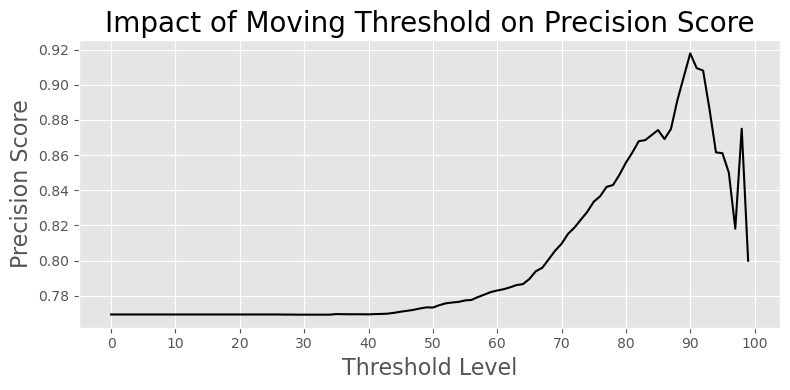

In [175]:
plt.figure(figsize=(8,4))
plt.style.use('default')
plt.style.use('ggplot')

plt.title('Impact of Moving Threshold on Precision Score', fontsize=20, color='black')

sns.lineplot(data=optimal, x='Threshold Level', y='Precision Score', color='black').set(xticks=np.arange(0,110,10))

plt.xlabel('Threshold Level', fontsize=16)
plt.ylabel('Precision Score', fontsize=16);

plt.tight_layout()
plt.show();

In [134]:
#Applying Moving Threshold to Logistic Regression
#Obtaining classification based on desired threshold of 0.9 (Same as standard Logistic Regression): 
y_pred_success_90 = (y_pred_prob[:, 1] > 0.90).astype('float')
y_pred_success_90

array([0., 0., 0., ..., 0., 0., 0.])

In [135]:
conf_mat = confusion_matrix(y, y_pred_success_90)
conf_mat

array([[1074,   30],
       [3349,  335]])

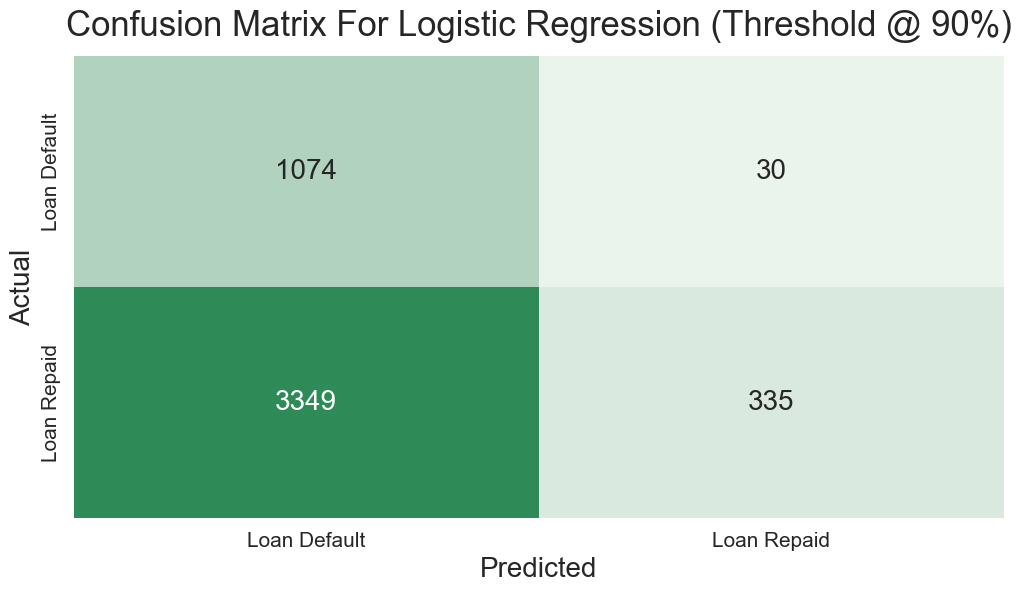

In [136]:
sns.set(rc = {'figure.figsize':(12,6)})
#cmap = sns.cubehelix_palette(start=2, rot=0, dark=0, light=.95, reverse=True, as_cmap=True)
cmap = sns.light_palette('seagreen', as_cmap=True)

res = sns.heatmap(conf_mat, annot=True, fmt='d', annot_kws={"size":20},
#            xticklabels = ['Good = Paid In Full', 'Bad = Default'],
#            yticklabels = ['Loan Paid In Full', 'Bad = Default'], 
            cmap=cmap, cbar=False)

res.set_xticklabels(['Loan Default', 'Loan Repaid'], fontsize=15)
res.set_yticklabels(['Loan Default', 'Loan Repaid'], fontsize=15)


plt.title('Confusion Matrix For Logistic Regression (Threshold @ 90%)', fontsize=25, pad=15)
plt.xlabel('Predicted', fontsize=20)
plt.ylabel('Actual', fontsize=20);

In [137]:
accuracy_score(y, y_pred_success_90)

0.29427736006683375

In [138]:
TN, FP, FN, TP = conf_mat.ravel()
print(TP)
print(FP)
print(FN)
print(TN)
print((TP + TN) / (TN + TP + FP + FN))

335
30
3349
1074
0.29427736006683375


In [139]:
#Positive Predictive Value (or Precision)
TP / (TP+FP)

0.9178082191780822

In [140]:
#Adding Logistic Regression Predictions to loans >= 20%
chosen['Predicted'] = y_pred_success_90

/var/folders/kl/4xt5tydd0xb8yvwkgnx2mnc00000gn/T/ipykernel_11679/1608700273.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chosen['Predicted'] = y_pred_success_90


In [141]:
#Segregating loans that were expected to perform by Logistic Regression
chosen_further_still = chosen[chosen.Predicted==1]
chosen_further_still.shape

(365, 156)

In [142]:
#Overall Return On Investment If Invested In Loans Predicted By LR ==> +10.5%
chosen_further_still['total_pymnt_inv'].sum() / chosen_further_still['funded_amnt_inv'].sum()

1.1339487592102673